# MNIST Overfitting
## Preparation

In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from copy import deepcopy

In [ ]:
# config
class CFG:
    # insert your api key here or load it from local environment
    api = ''
    project = "Overfitting MNIST"
    num_epoch = 300
    train_batch_size = 64
    test_batch_size = 512
    lr = 1e-3
    momentum = 0.9
    seed = 77
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

# set wandb api key
os.environ["WANDB_API_KEY"] = CFG.api

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

## Neural network models

In [ ]:
class FCnetwork(nn.Module):
    def __init__(self, n_hidden=2, n_nodes=[256, 128]):
        super(FCnetwork, self).__init__()
        if len(n_nodes) != n_hidden:
            raise ValueError('Length of n_nodes must be equal to n_hidden')
        # create per-layer number of nodes
        self.layer_nn = deepcopy(n_nodes)
        # input layer
        self.layer_nn.insert(0, 28*28)
        # output layer
        self.layer_nn.append(10)
        # all layers
        seq = []
        last_id = len(self.layer_nn) - 1
        for i, num_nodes in enumerate(self.layer_nn):
            if i == last_id:
                continue
            seq.append(nn.Linear(num_nodes, self.layer_nn[i+1]))
            if i+1 != last_id:
                seq.append(nn.ReLU())
        self.sq = nn.Sequential(*seq)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.sq(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
def train(model, device, loader, optimizer, criterion, epoch, WANDB=False, log=None):
    model.train()
    train_loss = 0
    correct = 0

    n = len(loader)

    for batch_ind, (data, target) in tqdm(enumerate(loader), total=n):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    accuracy = correct / len(loader.dataset)
    train_loss = train_loss/n
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * accuracy))

    if log is not None:
        log['train_loss'].append(train_loss)
        log['train_accuracy'].append(accuracy)

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': accuracy})


def test(model, device, loader, criterion, WANDB=False, log=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss = test_loss/len(loader)
    accuracy = correct / len(loader.dataset)
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * accuracy))

    if log is not None:
        log['test_loss'].append(test_loss)
        log['test_accuracy'].append(accuracy)

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': accuracy})

def train_test(tryset, device, optimizer, criterion, epoch, WANDB=True):
    print('Epoch: ', epoch)
    train(tryset['model'], device, tryset['train_loader'], optimizer, criterion, epoch, True, tryset['log'])
    test(tryset['model'], device, tryset['test_loader'], criterion, True, tryset['log'])

## Load Data

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_path = './MNIST_data'
train_data = datasets.MNIST(dataset_path, train=True, download=True, transform=mnist_transform)
test_data = datasets.MNIST(dataset_path, train=False, download=True, transform=mnist_transform)

## Train models
Обучим две одинаковые по архитектуре сети: 2 скрытых слоя размером 256 и 128 соответственно. Вторая сеть будет обучена на урезанных данных.

In [ ]:

set1 = {
    'description': '2 hidden layers, [256, 128]',
    'model': FCnetwork().cuda(),
    'train_loader': DataLoader(train_data, batch_size=CFG.train_batch_size, shuffle=False),
    'test_loader': DataLoader(test_data, batch_size=CFG.test_batch_size, shuffle=False),
    'log': {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
}

subset_train = Subset(train_data, range(1024))

set2 = {
    'description': '2 hidden layers, [256, 128], small training dataset',
    'model': FCnetwork().cuda(),
    'train_loader': DataLoader(subset_train, batch_size=CFG.train_batch_size, shuffle=False),
    'test_loader': DataLoader(test_data, batch_size=CFG.test_batch_size, shuffle=False),
    'log': {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
}

In [ ]:
import pickle
from os.path import join as path_join
def cache_var(var, filename, root='cache'):
    path = path_join(root, filename)
    with open(path, 'wb') as file:
        pickle.dump(var, file)

In [ ]:
to_train_sets = [set1, set2]
for s in to_train_sets:
    print(s['description'])
    optimizer = torch.optim.Adam(s['model'].parameters(), lr=CFG.lr)
    criterion = nn.CrossEntropyLoss()
    wandb.init(project=CFG.project, reinit=True, config=class2dict(CFG))
    for epoch in range(1, CFG.num_epoch + 1):
        train_test(s, 'cuda:0', optimizer, criterion, epoch)
    cache_var(s['log'], s['description'])
    print('============================================================================================================================================')

2 hidden layers, [256, 128]


test_accuracy,▅▇▇▇▇▇▆██████████████▇█▇█▇▇▁▇▇▇█████████
test_loss,▆▃▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇███▇████████████████████▄████████████
train_loss,█▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.8728
test_loss,1.58945
train_accuracy,0.96484
train_loss,1.4958


Epoch:  1


100%|██████████| 938/938 [00:14<00:00, 65.14it/s]



Train set: Average loss: 1.5792, Accuracy: 89%
Test set: Average loss: 1.5380, Accuracy: 93%
Epoch:  2


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]



Train set: Average loss: 1.5169, Accuracy: 95%
Test set: Average loss: 1.5070, Accuracy: 96%
Epoch:  3


100%|██████████| 938/938 [00:13<00:00, 67.59it/s]



Train set: Average loss: 1.5042, Accuracy: 96%
Test set: Average loss: 1.5013, Accuracy: 96%
Epoch:  4


100%|██████████| 938/938 [00:13<00:00, 68.35it/s]



Train set: Average loss: 1.4974, Accuracy: 96%
Test set: Average loss: 1.4999, Accuracy: 96%
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 70.31it/s]



Train set: Average loss: 1.4937, Accuracy: 97%
Test set: Average loss: 1.4948, Accuracy: 97%
Epoch:  6


100%|██████████| 938/938 [00:13<00:00, 71.98it/s]



Train set: Average loss: 1.4905, Accuracy: 97%
Test set: Average loss: 1.4935, Accuracy: 97%
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 69.34it/s]



Train set: Average loss: 1.4887, Accuracy: 97%
Test set: Average loss: 1.5002, Accuracy: 96%
Epoch:  8


100%|██████████| 938/938 [00:13<00:00, 70.35it/s]



Train set: Average loss: 1.4867, Accuracy: 97%
Test set: Average loss: 1.5091, Accuracy: 95%
Epoch:  9


100%|██████████| 938/938 [00:13<00:00, 68.33it/s]



Train set: Average loss: 1.4867, Accuracy: 97%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  10


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]



Train set: Average loss: 1.4864, Accuracy: 97%
Test set: Average loss: 1.4926, Accuracy: 97%
Epoch:  11


100%|██████████| 938/938 [00:13<00:00, 71.55it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  12


100%|██████████| 938/938 [00:13<00:00, 70.34it/s]



Train set: Average loss: 1.4835, Accuracy: 98%
Test set: Average loss: 1.4931, Accuracy: 97%
Epoch:  13


100%|██████████| 938/938 [00:13<00:00, 69.70it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  14


100%|██████████| 938/938 [00:13<00:00, 69.35it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  15


100%|██████████| 938/938 [00:13<00:00, 69.23it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  16


100%|██████████| 938/938 [00:13<00:00, 72.10it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4940, Accuracy: 97%
Epoch:  17


100%|██████████| 938/938 [00:13<00:00, 70.22it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  18


100%|██████████| 938/938 [00:14<00:00, 63.21it/s]



Train set: Average loss: 1.4798, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  19


100%|██████████| 938/938 [00:14<00:00, 66.36it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  20


100%|██████████| 938/938 [00:14<00:00, 66.00it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4948, Accuracy: 97%
Epoch:  21


100%|██████████| 938/938 [00:13<00:00, 68.09it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4929, Accuracy: 97%
Epoch:  22


100%|██████████| 938/938 [00:13<00:00, 68.06it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4965, Accuracy: 97%
Epoch:  23


100%|██████████| 938/938 [00:13<00:00, 68.51it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.5081, Accuracy: 95%
Epoch:  24


100%|██████████| 938/938 [00:13<00:00, 69.50it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4906, Accuracy: 97%
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 68.03it/s]



Train set: Average loss: 1.4807, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  26


100%|██████████| 938/938 [00:14<00:00, 66.63it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  27


100%|██████████| 938/938 [00:13<00:00, 69.21it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  28


100%|██████████| 938/938 [00:14<00:00, 65.41it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  29


100%|██████████| 938/938 [00:13<00:00, 70.24it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  30


100%|██████████| 938/938 [00:12<00:00, 73.76it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 98%
Epoch:  31


100%|██████████| 938/938 [00:13<00:00, 70.42it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4861, Accuracy: 98%
Epoch:  32


100%|██████████| 938/938 [00:13<00:00, 68.28it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  33


100%|██████████| 938/938 [00:14<00:00, 66.57it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  34


100%|██████████| 938/938 [00:13<00:00, 70.19it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4868, Accuracy: 98%
Epoch:  35


100%|██████████| 938/938 [00:12<00:00, 72.40it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  36


100%|██████████| 938/938 [00:13<00:00, 68.53it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4856, Accuracy: 98%
Epoch:  37


100%|██████████| 938/938 [00:13<00:00, 67.82it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  38


100%|██████████| 938/938 [00:13<00:00, 67.88it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  39


100%|██████████| 938/938 [00:13<00:00, 68.14it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  40


100%|██████████| 938/938 [00:13<00:00, 69.45it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  41


100%|██████████| 938/938 [00:13<00:00, 70.23it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.4883, Accuracy: 97%
Epoch:  42


100%|██████████| 938/938 [00:13<00:00, 68.79it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  43


100%|██████████| 938/938 [00:13<00:00, 71.32it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  44


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.4858, Accuracy: 98%
Epoch:  45


100%|██████████| 938/938 [00:14<00:00, 66.70it/s]



Train set: Average loss: 1.4771, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  46


100%|██████████| 938/938 [00:13<00:00, 70.54it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  47


100%|██████████| 938/938 [00:13<00:00, 69.52it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4963, Accuracy: 97%
Epoch:  48


100%|██████████| 938/938 [00:14<00:00, 65.65it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4941, Accuracy: 97%
Epoch:  49


100%|██████████| 938/938 [00:14<00:00, 66.71it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  50


100%|██████████| 938/938 [00:13<00:00, 70.74it/s]



Train set: Average loss: 1.4783, Accuracy: 98%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  51


100%|██████████| 938/938 [00:14<00:00, 66.45it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4935, Accuracy: 97%
Epoch:  52


100%|██████████| 938/938 [00:14<00:00, 66.01it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  53


100%|██████████| 938/938 [00:14<00:00, 65.70it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  54


100%|██████████| 938/938 [00:13<00:00, 68.31it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.4920, Accuracy: 97%
Epoch:  55


100%|██████████| 938/938 [00:13<00:00, 70.42it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4861, Accuracy: 98%
Epoch:  56


100%|██████████| 938/938 [00:13<00:00, 71.81it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4852, Accuracy: 98%
Epoch:  57


100%|██████████| 938/938 [00:13<00:00, 70.40it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  58


100%|██████████| 938/938 [00:13<00:00, 67.85it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 98%
Epoch:  59


100%|██████████| 938/938 [00:14<00:00, 65.85it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  60


100%|██████████| 938/938 [00:13<00:00, 71.12it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4864, Accuracy: 98%
Epoch:  61


100%|██████████| 938/938 [00:14<00:00, 65.36it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4926, Accuracy: 97%
Epoch:  62


100%|██████████| 938/938 [00:13<00:00, 69.53it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  63


100%|██████████| 938/938 [00:14<00:00, 65.44it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4866, Accuracy: 97%
Epoch:  64


100%|██████████| 938/938 [00:13<00:00, 69.82it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  65


100%|██████████| 938/938 [00:13<00:00, 70.08it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  66


100%|██████████| 938/938 [00:13<00:00, 71.67it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4934, Accuracy: 97%
Epoch:  67


100%|██████████| 938/938 [00:14<00:00, 66.25it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  68


100%|██████████| 938/938 [00:14<00:00, 63.90it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4874, Accuracy: 97%
Epoch:  69


100%|██████████| 938/938 [00:14<00:00, 66.90it/s]



Train set: Average loss: 1.4783, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  70


100%|██████████| 938/938 [00:14<00:00, 63.47it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  71


100%|██████████| 938/938 [00:14<00:00, 66.34it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  72


100%|██████████| 938/938 [00:13<00:00, 67.82it/s]



Train set: Average loss: 1.4751, Accuracy: 99%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  73


100%|██████████| 938/938 [00:13<00:00, 67.10it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  74


100%|██████████| 938/938 [00:13<00:00, 67.61it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.4864, Accuracy: 98%
Epoch:  75


100%|██████████| 938/938 [00:13<00:00, 67.04it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  76


100%|██████████| 938/938 [00:13<00:00, 68.21it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4917, Accuracy: 97%
Epoch:  77


100%|██████████| 938/938 [00:13<00:00, 67.39it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  78


100%|██████████| 938/938 [00:13<00:00, 67.22it/s]



Train set: Average loss: 1.4792, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  79


100%|██████████| 938/938 [00:13<00:00, 67.57it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4849, Accuracy: 98%
Epoch:  80


100%|██████████| 938/938 [00:13<00:00, 67.36it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4855, Accuracy: 98%
Epoch:  81


100%|██████████| 938/938 [00:14<00:00, 65.43it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  82


100%|██████████| 938/938 [00:14<00:00, 66.77it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4859, Accuracy: 98%
Epoch:  83


100%|██████████| 938/938 [00:14<00:00, 66.82it/s]



Train set: Average loss: 1.4807, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 98%
Epoch:  84


100%|██████████| 938/938 [00:14<00:00, 66.51it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.4873, Accuracy: 97%
Epoch:  85


100%|██████████| 938/938 [00:13<00:00, 67.24it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  86


100%|██████████| 938/938 [00:14<00:00, 66.60it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4868, Accuracy: 97%
Epoch:  87


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]



Train set: Average loss: 1.4792, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 97%
Epoch:  88


100%|██████████| 938/938 [00:14<00:00, 65.77it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  89


100%|██████████| 938/938 [00:13<00:00, 70.57it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  90


100%|██████████| 938/938 [00:12<00:00, 72.29it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.4898, Accuracy: 97%
Epoch:  91


100%|██████████| 938/938 [00:13<00:00, 71.87it/s]



Train set: Average loss: 1.4771, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  92


100%|██████████| 938/938 [00:13<00:00, 68.13it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  93


100%|██████████| 938/938 [00:14<00:00, 64.63it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  94


100%|██████████| 938/938 [00:14<00:00, 64.29it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.4842, Accuracy: 98%
Epoch:  95


100%|██████████| 938/938 [00:14<00:00, 63.04it/s]



Train set: Average loss: 1.4799, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  96


100%|██████████| 938/938 [00:14<00:00, 65.12it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4841, Accuracy: 98%
Epoch:  97


100%|██████████| 938/938 [00:14<00:00, 65.07it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4924, Accuracy: 97%
Epoch:  98


100%|██████████| 938/938 [00:13<00:00, 69.90it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  99


100%|██████████| 938/938 [00:14<00:00, 66.18it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  100


100%|██████████| 938/938 [00:14<00:00, 65.86it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.4868, Accuracy: 97%
Epoch:  101


100%|██████████| 938/938 [00:14<00:00, 63.37it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.4967, Accuracy: 96%
Epoch:  102


100%|██████████| 938/938 [00:14<00:00, 64.55it/s]



Train set: Average loss: 1.4770, Accuracy: 98%
Test set: Average loss: 1.4851, Accuracy: 98%
Epoch:  103


100%|██████████| 938/938 [00:13<00:00, 68.21it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4857, Accuracy: 98%
Epoch:  104


100%|██████████| 938/938 [00:13<00:00, 67.62it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4860, Accuracy: 98%
Epoch:  105


100%|██████████| 938/938 [00:13<00:00, 67.07it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.4864, Accuracy: 98%
Epoch:  106


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]



Train set: Average loss: 1.4783, Accuracy: 98%
Test set: Average loss: 1.4845, Accuracy: 98%
Epoch:  107


100%|██████████| 938/938 [00:13<00:00, 69.01it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  108


100%|██████████| 938/938 [00:13<00:00, 70.98it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  109


100%|██████████| 938/938 [00:13<00:00, 71.31it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  110


100%|██████████| 938/938 [00:13<00:00, 68.25it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  111


100%|██████████| 938/938 [00:13<00:00, 70.13it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4868, Accuracy: 97%
Epoch:  112


100%|██████████| 938/938 [00:13<00:00, 67.94it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  113


100%|██████████| 938/938 [00:13<00:00, 70.07it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  114


100%|██████████| 938/938 [00:13<00:00, 68.01it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.4843, Accuracy: 98%
Epoch:  115


100%|██████████| 938/938 [00:14<00:00, 62.94it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.4863, Accuracy: 97%
Epoch:  116


100%|██████████| 938/938 [00:14<00:00, 66.87it/s]



Train set: Average loss: 1.4771, Accuracy: 98%
Test set: Average loss: 1.4947, Accuracy: 97%
Epoch:  117


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  118


100%|██████████| 938/938 [00:13<00:00, 67.86it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  119


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  120


100%|██████████| 938/938 [00:13<00:00, 68.29it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  121


100%|██████████| 938/938 [00:13<00:00, 67.88it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4938, Accuracy: 97%
Epoch:  122


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4864, Accuracy: 97%
Epoch:  123


100%|██████████| 938/938 [00:13<00:00, 69.16it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  124


100%|██████████| 938/938 [00:14<00:00, 66.96it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  125


100%|██████████| 938/938 [00:14<00:00, 64.30it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  126


100%|██████████| 938/938 [00:14<00:00, 65.78it/s]



Train set: Average loss: 1.4799, Accuracy: 98%
Test set: Average loss: 1.4874, Accuracy: 97%
Epoch:  127


100%|██████████| 938/938 [00:14<00:00, 66.59it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4924, Accuracy: 97%
Epoch:  128


100%|██████████| 938/938 [00:13<00:00, 71.12it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  129


100%|██████████| 938/938 [00:13<00:00, 68.95it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  130


100%|██████████| 938/938 [00:14<00:00, 66.48it/s]



Train set: Average loss: 1.4807, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  131


100%|██████████| 938/938 [00:13<00:00, 70.12it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  132


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]



Train set: Average loss: 1.4792, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  133


100%|██████████| 938/938 [00:13<00:00, 69.44it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  134


100%|██████████| 938/938 [00:13<00:00, 69.24it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  135


100%|██████████| 938/938 [00:13<00:00, 69.99it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  136


100%|██████████| 938/938 [00:13<00:00, 69.78it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  137


100%|██████████| 938/938 [00:13<00:00, 69.56it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4906, Accuracy: 97%
Epoch:  138


100%|██████████| 938/938 [00:13<00:00, 67.92it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  139


100%|██████████| 938/938 [00:13<00:00, 69.42it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.4929, Accuracy: 97%
Epoch:  140


100%|██████████| 938/938 [00:13<00:00, 67.92it/s]



Train set: Average loss: 1.4813, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  141


100%|██████████| 938/938 [00:14<00:00, 64.62it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  142


100%|██████████| 938/938 [00:13<00:00, 71.44it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  143


100%|██████████| 938/938 [00:13<00:00, 69.19it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4934, Accuracy: 97%
Epoch:  144


100%|██████████| 938/938 [00:13<00:00, 68.97it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.4857, Accuracy: 98%
Epoch:  145


100%|██████████| 938/938 [00:14<00:00, 66.04it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4851, Accuracy: 98%
Epoch:  146


100%|██████████| 938/938 [00:13<00:00, 70.38it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.5143, Accuracy: 95%
Epoch:  147


100%|██████████| 938/938 [00:13<00:00, 70.45it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  148


100%|██████████| 938/938 [00:13<00:00, 71.19it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4855, Accuracy: 98%
Epoch:  149


100%|██████████| 938/938 [00:13<00:00, 69.49it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  150


100%|██████████| 938/938 [00:13<00:00, 68.77it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  151


100%|██████████| 938/938 [00:14<00:00, 66.88it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  152


100%|██████████| 938/938 [00:14<00:00, 64.31it/s]



Train set: Average loss: 1.4772, Accuracy: 98%
Test set: Average loss: 1.4944, Accuracy: 97%
Epoch:  153


100%|██████████| 938/938 [00:14<00:00, 66.83it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  154


100%|██████████| 938/938 [00:14<00:00, 66.93it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  155


100%|██████████| 938/938 [00:14<00:00, 66.20it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4838, Accuracy: 98%
Epoch:  156


100%|██████████| 938/938 [00:14<00:00, 65.90it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  157


100%|██████████| 938/938 [00:13<00:00, 67.32it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  158


100%|██████████| 938/938 [00:14<00:00, 66.43it/s]



Train set: Average loss: 1.4817, Accuracy: 98%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  159


100%|██████████| 938/938 [00:13<00:00, 67.33it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  160


100%|██████████| 938/938 [00:14<00:00, 66.13it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  161


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4866, Accuracy: 98%
Epoch:  162


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  163


100%|██████████| 938/938 [00:14<00:00, 66.68it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  164


100%|██████████| 938/938 [00:13<00:00, 67.32it/s]



Train set: Average loss: 1.4759, Accuracy: 99%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  165


100%|██████████| 938/938 [00:13<00:00, 68.85it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4842, Accuracy: 98%
Epoch:  166


100%|██████████| 938/938 [00:13<00:00, 71.25it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  167


100%|██████████| 938/938 [00:13<00:00, 67.32it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  168


100%|██████████| 938/938 [00:13<00:00, 70.06it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  169


100%|██████████| 938/938 [00:13<00:00, 71.14it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4929, Accuracy: 97%
Epoch:  170


100%|██████████| 938/938 [00:13<00:00, 70.51it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  171


100%|██████████| 938/938 [00:13<00:00, 68.04it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.4844, Accuracy: 98%
Epoch:  172


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4856, Accuracy: 98%
Epoch:  173


100%|██████████| 938/938 [00:14<00:00, 66.49it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  174


100%|██████████| 938/938 [00:13<00:00, 67.15it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.4951, Accuracy: 97%
Epoch:  175


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.5113, Accuracy: 95%
Epoch:  176


100%|██████████| 938/938 [00:13<00:00, 68.04it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.4854, Accuracy: 98%
Epoch:  177


100%|██████████| 938/938 [00:13<00:00, 68.22it/s]



Train set: Average loss: 1.4760, Accuracy: 99%
Test set: Average loss: 1.4837, Accuracy: 98%
Epoch:  178


100%|██████████| 938/938 [00:13<00:00, 69.70it/s]



Train set: Average loss: 1.4769, Accuracy: 98%
Test set: Average loss: 1.4890, Accuracy: 97%
Epoch:  179


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  180


100%|██████████| 938/938 [00:13<00:00, 72.10it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4872, Accuracy: 97%
Epoch:  181


100%|██████████| 938/938 [00:13<00:00, 70.73it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4842, Accuracy: 98%
Epoch:  182


100%|██████████| 938/938 [00:13<00:00, 68.11it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  183


100%|██████████| 938/938 [00:13<00:00, 71.19it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  184


100%|██████████| 938/938 [00:13<00:00, 69.02it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4936, Accuracy: 97%
Epoch:  185


100%|██████████| 938/938 [00:13<00:00, 68.20it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.4952, Accuracy: 97%
Epoch:  186


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  187


100%|██████████| 938/938 [00:13<00:00, 69.06it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  188


100%|██████████| 938/938 [00:13<00:00, 69.26it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  189


100%|██████████| 938/938 [00:13<00:00, 67.31it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4845, Accuracy: 98%
Epoch:  190


100%|██████████| 938/938 [00:13<00:00, 67.51it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4902, Accuracy: 97%
Epoch:  191


100%|██████████| 938/938 [00:13<00:00, 67.82it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  192


100%|██████████| 938/938 [00:14<00:00, 65.96it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  193


100%|██████████| 938/938 [00:14<00:00, 64.03it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4966, Accuracy: 97%
Epoch:  194


100%|██████████| 938/938 [00:13<00:00, 67.82it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4954, Accuracy: 97%
Epoch:  195


100%|██████████| 938/938 [00:13<00:00, 68.80it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.4858, Accuracy: 98%
Epoch:  196


100%|██████████| 938/938 [00:13<00:00, 67.10it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.5041, Accuracy: 96%
Epoch:  197


100%|██████████| 938/938 [00:13<00:00, 69.99it/s]



Train set: Average loss: 1.4867, Accuracy: 97%
Test set: Average loss: 1.4947, Accuracy: 97%
Epoch:  198


100%|██████████| 938/938 [00:14<00:00, 66.44it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  199


100%|██████████| 938/938 [00:13<00:00, 69.43it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4980, Accuracy: 96%
Epoch:  200


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  201


100%|██████████| 938/938 [00:13<00:00, 69.28it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.4857, Accuracy: 98%
Epoch:  202


100%|██████████| 938/938 [00:13<00:00, 70.01it/s]



Train set: Average loss: 1.4772, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  203


100%|██████████| 938/938 [00:14<00:00, 65.47it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  204


100%|██████████| 938/938 [00:13<00:00, 68.05it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.4916, Accuracy: 97%
Epoch:  205


100%|██████████| 938/938 [00:13<00:00, 67.94it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.4930, Accuracy: 97%
Epoch:  206


100%|██████████| 938/938 [00:14<00:00, 65.75it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  207


100%|██████████| 938/938 [00:13<00:00, 67.24it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  208


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  209


100%|██████████| 938/938 [00:13<00:00, 68.15it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  210


100%|██████████| 938/938 [00:14<00:00, 66.16it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  211


100%|██████████| 938/938 [00:14<00:00, 65.65it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  212


100%|██████████| 938/938 [00:13<00:00, 69.66it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  213


100%|██████████| 938/938 [00:13<00:00, 69.21it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  214


100%|██████████| 938/938 [00:13<00:00, 70.82it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  215


100%|██████████| 938/938 [00:13<00:00, 67.60it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  216


100%|██████████| 938/938 [00:13<00:00, 69.15it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  217


100%|██████████| 938/938 [00:13<00:00, 69.81it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  218


100%|██████████| 938/938 [00:13<00:00, 68.34it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  219


100%|██████████| 938/938 [00:13<00:00, 68.26it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  220


100%|██████████| 938/938 [00:13<00:00, 67.37it/s]



Train set: Average loss: 1.4832, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  221


100%|██████████| 938/938 [00:14<00:00, 65.06it/s]



Train set: Average loss: 1.4769, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  222


100%|██████████| 938/938 [00:13<00:00, 67.83it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  223


100%|██████████| 938/938 [00:14<00:00, 65.16it/s]



Train set: Average loss: 1.4778, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  224


100%|██████████| 938/938 [00:13<00:00, 69.46it/s]



Train set: Average loss: 1.4800, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  225


100%|██████████| 938/938 [00:13<00:00, 67.05it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4942, Accuracy: 97%
Epoch:  226


100%|██████████| 938/938 [00:14<00:00, 64.87it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.4909, Accuracy: 97%
Epoch:  227


100%|██████████| 938/938 [00:14<00:00, 66.85it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  228


100%|██████████| 938/938 [00:14<00:00, 65.84it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4908, Accuracy: 97%
Epoch:  229


100%|██████████| 938/938 [00:13<00:00, 68.49it/s]



Train set: Average loss: 1.4799, Accuracy: 98%
Test set: Average loss: 1.4906, Accuracy: 97%
Epoch:  230


100%|██████████| 938/938 [00:14<00:00, 66.68it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.5050, Accuracy: 96%
Epoch:  231


100%|██████████| 938/938 [00:13<00:00, 69.01it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  232


100%|██████████| 938/938 [00:13<00:00, 69.54it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  233


100%|██████████| 938/938 [00:13<00:00, 68.85it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  234


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  235


100%|██████████| 938/938 [00:13<00:00, 67.15it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  236


100%|██████████| 938/938 [00:13<00:00, 69.44it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  237


100%|██████████| 938/938 [00:13<00:00, 67.73it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  238


100%|██████████| 938/938 [00:14<00:00, 66.59it/s]



Train set: Average loss: 1.4771, Accuracy: 98%
Test set: Average loss: 1.4872, Accuracy: 97%
Epoch:  239


100%|██████████| 938/938 [00:13<00:00, 67.98it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  240


100%|██████████| 938/938 [00:14<00:00, 66.60it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4945, Accuracy: 97%
Epoch:  241


100%|██████████| 938/938 [00:13<00:00, 67.57it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  242


100%|██████████| 938/938 [00:14<00:00, 63.69it/s]



Train set: Average loss: 1.4771, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  243


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  244


100%|██████████| 938/938 [00:13<00:00, 70.04it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  245


100%|██████████| 938/938 [00:13<00:00, 70.15it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  246


100%|██████████| 938/938 [00:13<00:00, 70.83it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  247


100%|██████████| 938/938 [00:13<00:00, 67.97it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.4848, Accuracy: 98%
Epoch:  248


100%|██████████| 938/938 [00:13<00:00, 70.54it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  249


100%|██████████| 938/938 [00:13<00:00, 67.09it/s]



Train set: Average loss: 1.4799, Accuracy: 98%
Test set: Average loss: 1.4971, Accuracy: 96%
Epoch:  250


100%|██████████| 938/938 [00:14<00:00, 66.99it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4961, Accuracy: 97%
Epoch:  251


100%|██████████| 938/938 [00:13<00:00, 68.62it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4859, Accuracy: 98%
Epoch:  252


100%|██████████| 938/938 [00:13<00:00, 67.29it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4853, Accuracy: 98%
Epoch:  253


100%|██████████| 938/938 [00:13<00:00, 67.41it/s]



Train set: Average loss: 1.4781, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 98%
Epoch:  254


100%|██████████| 938/938 [00:13<00:00, 69.04it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4946, Accuracy: 97%
Epoch:  255


100%|██████████| 938/938 [00:14<00:00, 66.78it/s]



Train set: Average loss: 1.4821, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  256


100%|██████████| 938/938 [00:14<00:00, 66.65it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4963, Accuracy: 97%
Epoch:  257


100%|██████████| 938/938 [00:13<00:00, 67.96it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  258


100%|██████████| 938/938 [00:14<00:00, 64.50it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  259


100%|██████████| 938/938 [00:14<00:00, 64.52it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4925, Accuracy: 97%
Epoch:  260


100%|██████████| 938/938 [00:14<00:00, 66.71it/s]



Train set: Average loss: 1.4900, Accuracy: 97%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  261


100%|██████████| 938/938 [00:14<00:00, 65.04it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  262


100%|██████████| 938/938 [00:14<00:00, 66.42it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  263


100%|██████████| 938/938 [00:14<00:00, 64.84it/s]



Train set: Average loss: 1.4792, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  264


100%|██████████| 938/938 [00:14<00:00, 62.60it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.4874, Accuracy: 97%
Epoch:  265


100%|██████████| 938/938 [00:14<00:00, 65.86it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  266


100%|██████████| 938/938 [00:14<00:00, 66.86it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  267


100%|██████████| 938/938 [00:13<00:00, 70.13it/s]



Train set: Average loss: 1.4787, Accuracy: 98%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  268


100%|██████████| 938/938 [00:13<00:00, 67.39it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  269


100%|██████████| 938/938 [00:13<00:00, 69.64it/s]



Train set: Average loss: 1.4821, Accuracy: 98%
Test set: Average loss: 1.4890, Accuracy: 97%
Epoch:  270


100%|██████████| 938/938 [00:13<00:00, 67.96it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  271


100%|██████████| 938/938 [00:13<00:00, 68.78it/s]



Train set: Average loss: 1.4760, Accuracy: 99%
Test set: Average loss: 1.4862, Accuracy: 98%
Epoch:  272


100%|██████████| 938/938 [00:13<00:00, 67.72it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  273


100%|██████████| 938/938 [00:14<00:00, 65.70it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  274


100%|██████████| 938/938 [00:14<00:00, 66.97it/s]



Train set: Average loss: 1.4817, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  275


100%|██████████| 938/938 [00:13<00:00, 67.69it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4926, Accuracy: 97%
Epoch:  276


100%|██████████| 938/938 [00:13<00:00, 67.17it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4847, Accuracy: 98%
Epoch:  277


100%|██████████| 938/938 [00:14<00:00, 66.50it/s]



Train set: Average loss: 1.4766, Accuracy: 98%
Test set: Average loss: 1.4867, Accuracy: 98%
Epoch:  278


100%|██████████| 938/938 [00:14<00:00, 66.56it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  279


100%|██████████| 938/938 [00:14<00:00, 66.52it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  280


100%|██████████| 938/938 [00:14<00:00, 66.71it/s]



Train set: Average loss: 1.4783, Accuracy: 98%
Test set: Average loss: 1.4955, Accuracy: 97%
Epoch:  281


100%|██████████| 938/938 [00:14<00:00, 66.34it/s]



Train set: Average loss: 1.4813, Accuracy: 98%
Test set: Average loss: 1.4952, Accuracy: 97%
Epoch:  282


100%|██████████| 938/938 [00:14<00:00, 66.79it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4920, Accuracy: 97%
Epoch:  283


100%|██████████| 938/938 [00:14<00:00, 66.70it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  284


100%|██████████| 938/938 [00:14<00:00, 66.72it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  285


100%|██████████| 938/938 [00:13<00:00, 67.16it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  286


100%|██████████| 938/938 [00:14<00:00, 64.98it/s]



Train set: Average loss: 1.4792, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  287


100%|██████████| 938/938 [00:16<00:00, 58.15it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4961, Accuracy: 97%
Epoch:  288


100%|██████████| 938/938 [00:14<00:00, 64.68it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  289


100%|██████████| 938/938 [00:14<00:00, 64.68it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  290


100%|██████████| 938/938 [00:14<00:00, 65.16it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  291


100%|██████████| 938/938 [00:14<00:00, 64.49it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4924, Accuracy: 97%
Epoch:  292


100%|██████████| 938/938 [00:14<00:00, 64.43it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  293


100%|██████████| 938/938 [00:14<00:00, 66.90it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  294


100%|██████████| 938/938 [00:14<00:00, 64.56it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  295


100%|██████████| 938/938 [00:14<00:00, 64.99it/s]



Train set: Average loss: 1.4827, Accuracy: 98%
Test set: Average loss: 1.4883, Accuracy: 97%
Epoch:  296


100%|██████████| 938/938 [00:14<00:00, 64.69it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  297


100%|██████████| 938/938 [00:13<00:00, 67.18it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  298


100%|██████████| 938/938 [00:13<00:00, 67.20it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  299


100%|██████████| 938/938 [00:14<00:00, 63.00it/s]



Train set: Average loss: 1.4782, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  300


100%|██████████| 938/938 [00:14<00:00, 65.87it/s]



Train set: Average loss: 1.4773, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
2 hidden layers, [256, 128], small training dataset


test_accuracy,▄▁▅▆▇▇▅█▇▇▆▇█▇▇▅▇▇▆█▅▇▆█▅▆▇▇▆▆▆▇▆█▆▇█▇▇▇
test_loss,▅█▄▃▂▁▄▁▂▂▃▂▁▂▂▄▂▁▃▁▄▂▃▁▄▃▂▂▂▃▃▂▃▁▃▂▁▂▂▂
train_accuracy,▁▄▆▆▇▇▇▇▇█▆▆▆▇▇▇▇▇▆▇▇▆▆▆▇▇▆▇▆▆▇▆▇▇▃▇▇▇▆▇
train_loss,█▅▃▃▂▂▂▂▂▁▃▃▃▂▂▂▂▂▃▂▂▃▃▃▂▂▃▂▃▃▂▃▂▂▆▂▂▂▃▂
test_accuracy,0.9739
test_loss,1.48778
train_accuracy,0.98385
train_loss,1.47729


Epoch:  1


100%|██████████| 16/16 [00:00<00:00, 54.42it/s]



Train set: Average loss: 2.1104, Accuracy: 52%
Test set: Average loss: 1.8872, Accuracy: 62%
Epoch:  2


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.7985, Accuracy: 68%
Test set: Average loss: 1.8109, Accuracy: 67%
Epoch:  3


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.7345, Accuracy: 73%
Test set: Average loss: 1.7092, Accuracy: 78%
Epoch:  4


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]



Train set: Average loss: 1.6281, Accuracy: 86%
Test set: Average loss: 1.6486, Accuracy: 84%
Epoch:  5


100%|██████████| 16/16 [00:00<00:00, 56.34it/s]



Train set: Average loss: 1.5749, Accuracy: 91%
Test set: Average loss: 1.6299, Accuracy: 85%
Epoch:  6


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.5551, Accuracy: 92%
Test set: Average loss: 1.6262, Accuracy: 85%
Epoch:  7


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.5486, Accuracy: 92%
Test set: Average loss: 1.6243, Accuracy: 85%
Epoch:  8


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.5480, Accuracy: 92%
Test set: Average loss: 1.6353, Accuracy: 84%
Epoch:  9


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]



Train set: Average loss: 1.5353, Accuracy: 94%
Test set: Average loss: 1.6295, Accuracy: 84%
Epoch:  10


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.5177, Accuracy: 95%
Test set: Average loss: 1.5913, Accuracy: 88%
Epoch:  11


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.5038, Accuracy: 96%
Test set: Average loss: 1.5890, Accuracy: 88%
Epoch:  12


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4996, Accuracy: 97%
Test set: Average loss: 1.6036, Accuracy: 86%
Epoch:  13


100%|██████████| 16/16 [00:00<00:00, 58.18it/s]



Train set: Average loss: 1.4941, Accuracy: 97%
Test set: Average loss: 1.5886, Accuracy: 88%
Epoch:  14


100%|██████████| 16/16 [00:00<00:00, 65.31it/s]



Train set: Average loss: 1.4900, Accuracy: 97%
Test set: Average loss: 1.5910, Accuracy: 88%
Epoch:  15


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4885, Accuracy: 98%
Test set: Average loss: 1.5951, Accuracy: 87%
Epoch:  16


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4866, Accuracy: 98%
Test set: Average loss: 1.5893, Accuracy: 88%
Epoch:  17


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4851, Accuracy: 98%
Test set: Average loss: 1.5887, Accuracy: 88%
Epoch:  18


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4845, Accuracy: 98%
Test set: Average loss: 1.5890, Accuracy: 88%
Epoch:  19


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.5883, Accuracy: 88%
Epoch:  20


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.4841, Accuracy: 98%
Test set: Average loss: 1.5881, Accuracy: 88%
Epoch:  21


100%|██████████| 16/16 [00:00<00:00, 55.75it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.5877, Accuracy: 88%
Epoch:  22


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.5874, Accuracy: 88%
Epoch:  23


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.5870, Accuracy: 88%
Epoch:  24


100%|██████████| 16/16 [00:00<00:00, 56.34it/s]



Train set: Average loss: 1.4831, Accuracy: 98%
Test set: Average loss: 1.5867, Accuracy: 88%
Epoch:  25


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.5867, Accuracy: 88%
Epoch:  26


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.5857, Accuracy: 88%
Epoch:  27


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.5861, Accuracy: 88%
Epoch:  28


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4817, Accuracy: 98%
Test set: Average loss: 1.5865, Accuracy: 88%
Epoch:  29


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.5875, Accuracy: 88%
Epoch:  30


100%|██████████| 16/16 [00:00<00:00, 64.51it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.5867, Accuracy: 88%
Epoch:  31


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.4807, Accuracy: 98%
Test set: Average loss: 1.5861, Accuracy: 88%
Epoch:  32


100%|██████████| 16/16 [00:00<00:00, 57.55it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.5864, Accuracy: 88%
Epoch:  33


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.5856, Accuracy: 88%
Epoch:  34


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.5861, Accuracy: 88%
Epoch:  35


100%|██████████| 16/16 [00:00<00:00, 66.66it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.5851, Accuracy: 88%
Epoch:  36


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.5860, Accuracy: 88%
Epoch:  37


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5848, Accuracy: 88%
Epoch:  38


100%|██████████| 16/16 [00:00<00:00, 62.01it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5859, Accuracy: 88%
Epoch:  39


100%|██████████| 16/16 [00:00<00:00, 65.30it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5846, Accuracy: 88%
Epoch:  40


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5858, Accuracy: 88%
Epoch:  41


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5845, Accuracy: 88%
Epoch:  42


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5857, Accuracy: 88%
Epoch:  43


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5843, Accuracy: 88%
Epoch:  44


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5857, Accuracy: 88%
Epoch:  45


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5842, Accuracy: 88%
Epoch:  46


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5856, Accuracy: 88%
Epoch:  47


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5840, Accuracy: 88%
Epoch:  48


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5855, Accuracy: 88%
Epoch:  49


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5839, Accuracy: 88%
Epoch:  50


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5856, Accuracy: 88%
Epoch:  51


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5836, Accuracy: 88%
Epoch:  52


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5854, Accuracy: 88%
Epoch:  53


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5836, Accuracy: 88%
Epoch:  54


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5854, Accuracy: 88%
Epoch:  55


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5835, Accuracy: 88%
Epoch:  56


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5852, Accuracy: 88%
Epoch:  57


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5835, Accuracy: 88%
Epoch:  58


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5854, Accuracy: 88%
Epoch:  59


100%|██████████| 16/16 [00:00<00:00, 61.77it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5834, Accuracy: 88%
Epoch:  60


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5852, Accuracy: 88%
Epoch:  61


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5835, Accuracy: 88%
Epoch:  62


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5852, Accuracy: 88%
Epoch:  63


100%|██████████| 16/16 [00:00<00:00, 66.11it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5835, Accuracy: 88%
Epoch:  64


100%|██████████| 16/16 [00:00<00:00, 65.85it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5852, Accuracy: 88%
Epoch:  65


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5834, Accuracy: 88%
Epoch:  66


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5853, Accuracy: 88%
Epoch:  67


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5833, Accuracy: 88%
Epoch:  68


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5849, Accuracy: 88%
Epoch:  69


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5833, Accuracy: 88%
Epoch:  70


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5849, Accuracy: 88%
Epoch:  71


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5831, Accuracy: 88%
Epoch:  72


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5848, Accuracy: 88%
Epoch:  73


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5829, Accuracy: 88%
Epoch:  74


100%|██████████| 16/16 [00:00<00:00, 64.78it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5846, Accuracy: 88%
Epoch:  75


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.5829, Accuracy: 88%
Epoch:  76


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.5852, Accuracy: 88%
Epoch:  77


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.5811, Accuracy: 88%
Epoch:  78


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.5833, Accuracy: 88%
Epoch:  79


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.4833, Accuracy: 98%
Test set: Average loss: 1.5932, Accuracy: 87%
Epoch:  80


100%|██████████| 16/16 [00:00<00:00, 61.77it/s]



Train set: Average loss: 1.4930, Accuracy: 97%
Test set: Average loss: 1.6068, Accuracy: 86%
Epoch:  81


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4955, Accuracy: 97%
Test set: Average loss: 1.6014, Accuracy: 86%
Epoch:  82


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4974, Accuracy: 97%
Test set: Average loss: 1.6195, Accuracy: 85%
Epoch:  83


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4952, Accuracy: 97%
Test set: Average loss: 1.6286, Accuracy: 83%
Epoch:  84


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.5000, Accuracy: 97%
Test set: Average loss: 1.6081, Accuracy: 86%
Epoch:  85


100%|██████████| 16/16 [00:00<00:00, 52.29it/s]



Train set: Average loss: 1.4982, Accuracy: 96%
Test set: Average loss: 1.6034, Accuracy: 86%
Epoch:  86


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]



Train set: Average loss: 1.5010, Accuracy: 96%
Test set: Average loss: 1.6058, Accuracy: 86%
Epoch:  87


100%|██████████| 16/16 [00:00<00:00, 66.94it/s]



Train set: Average loss: 1.4925, Accuracy: 97%
Test set: Average loss: 1.6061, Accuracy: 86%
Epoch:  88


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4870, Accuracy: 97%
Test set: Average loss: 1.5838, Accuracy: 88%
Epoch:  89


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.5791, Accuracy: 88%
Epoch:  90


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5836, Accuracy: 88%
Epoch:  91


100%|██████████| 16/16 [00:00<00:00, 60.37it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.5839, Accuracy: 88%
Epoch:  92


100%|██████████| 16/16 [00:00<00:00, 59.92it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5830, Accuracy: 88%
Epoch:  93


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5820, Accuracy: 88%
Epoch:  94


100%|██████████| 16/16 [00:00<00:00, 53.33it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5812, Accuracy: 88%
Epoch:  95


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4769, Accuracy: 98%
Test set: Average loss: 1.5884, Accuracy: 87%
Epoch:  96


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5820, Accuracy: 88%
Epoch:  97


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.5805, Accuracy: 88%
Epoch:  98


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4766, Accuracy: 98%
Test set: Average loss: 1.5780, Accuracy: 88%
Epoch:  99


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4766, Accuracy: 98%
Test set: Average loss: 1.5770, Accuracy: 89%
Epoch:  100


100%|██████████| 16/16 [00:00<00:00, 51.95it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5767, Accuracy: 89%
Epoch:  101


100%|██████████| 16/16 [00:00<00:00, 56.14it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5756, Accuracy: 89%
Epoch:  102


100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5759, Accuracy: 89%
Epoch:  103


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  104


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  105


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  106


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  107


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  108


100%|██████████| 16/16 [00:00<00:00, 64.78it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  109


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  110


100%|██████████| 16/16 [00:00<00:00, 56.94it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  111


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  112


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  113


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  114


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  115


100%|██████████| 16/16 [00:00<00:00, 65.31it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  116


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  117


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  118


100%|██████████| 16/16 [00:00<00:00, 56.34it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  119


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  120


100%|██████████| 16/16 [00:00<00:00, 61.77it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  121


100%|██████████| 16/16 [00:00<00:00, 54.42it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  122


100%|██████████| 16/16 [00:00<00:00, 56.14it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  123


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  124


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  125


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  126


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  127


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  128


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  129


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  130


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5739, Accuracy: 89%
Epoch:  131


100%|██████████| 16/16 [00:00<00:00, 65.30it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5739, Accuracy: 89%
Epoch:  132


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  133


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  134


100%|██████████| 16/16 [00:00<00:00, 49.23it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  135


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  136


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5737, Accuracy: 89%
Epoch:  137


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  138


100%|██████████| 16/16 [00:00<00:00, 58.18it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  139


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  140


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  141


100%|██████████| 16/16 [00:00<00:00, 54.98it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  142


100%|██████████| 16/16 [00:00<00:00, 57.55it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  143


100%|██████████| 16/16 [00:00<00:00, 50.79it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  144


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  145


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  146


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  147


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  148


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  149


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  150


100%|██████████| 16/16 [00:00<00:00, 57.76it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5758, Accuracy: 89%
Epoch:  151


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5754, Accuracy: 89%
Epoch:  152


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5739, Accuracy: 89%
Epoch:  153


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  154


100%|██████████| 16/16 [00:00<00:00, 58.82it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  155


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  156


100%|██████████| 16/16 [00:00<00:00, 69.27it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  157


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  158


100%|██████████| 16/16 [00:00<00:00, 55.36it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  159


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5754, Accuracy: 89%
Epoch:  160


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  161


100%|██████████| 16/16 [00:00<00:00, 55.56it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  162


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  163


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  164


100%|██████████| 16/16 [00:00<00:00, 68.67it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  165


100%|██████████| 16/16 [00:00<00:00, 54.80it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  166


100%|██████████| 16/16 [00:00<00:00, 53.51it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  167


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  168


100%|██████████| 16/16 [00:00<00:00, 67.23it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  169


100%|██████████| 16/16 [00:00<00:00, 54.79it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  170


100%|██████████| 16/16 [00:00<00:00, 58.40it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  171


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5734, Accuracy: 89%
Epoch:  172


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5720, Accuracy: 89%
Epoch:  173


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5734, Accuracy: 89%
Epoch:  174


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5723, Accuracy: 89%
Epoch:  175


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5729, Accuracy: 89%
Epoch:  176


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5738, Accuracy: 89%
Epoch:  177


100%|██████████| 16/16 [00:00<00:00, 54.79it/s]



Train set: Average loss: 1.4765, Accuracy: 98%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  178


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4764, Accuracy: 98%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  179


100%|██████████| 16/16 [00:00<00:00, 68.67it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5756, Accuracy: 89%
Epoch:  180


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  181


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  182


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  183


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5736, Accuracy: 89%
Epoch:  184


100%|██████████| 16/16 [00:00<00:00, 66.94it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  185


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  186


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5730, Accuracy: 89%
Epoch:  187


100%|██████████| 16/16 [00:00<00:00, 68.97it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  188


100%|██████████| 16/16 [00:00<00:00, 69.26it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  189


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5734, Accuracy: 89%
Epoch:  190


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5736, Accuracy: 89%
Epoch:  191


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5733, Accuracy: 89%
Epoch:  192


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  193


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  194


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  195


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5737, Accuracy: 89%
Epoch:  196


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5745, Accuracy: 89%
Epoch:  197


100%|██████████| 16/16 [00:00<00:00, 68.08it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5737, Accuracy: 89%
Epoch:  198


100%|██████████| 16/16 [00:00<00:00, 58.39it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  199


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  200


100%|██████████| 16/16 [00:00<00:00, 68.37it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  201


100%|██████████| 16/16 [00:00<00:00, 66.94it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5726, Accuracy: 89%
Epoch:  202


100%|██████████| 16/16 [00:00<00:00, 61.31it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5725, Accuracy: 89%
Epoch:  203


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  204


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  205


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  206


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5729, Accuracy: 89%
Epoch:  207


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5732, Accuracy: 89%
Epoch:  208


100%|██████████| 16/16 [00:00<00:00, 67.51it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5747, Accuracy: 89%
Epoch:  209


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  210


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5721, Accuracy: 89%
Epoch:  211


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5722, Accuracy: 89%
Epoch:  212


100%|██████████| 16/16 [00:00<00:00, 63.74it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5728, Accuracy: 89%
Epoch:  213


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4754, Accuracy: 99%
Test set: Average loss: 1.5730, Accuracy: 89%
Epoch:  214


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5731, Accuracy: 89%
Epoch:  215


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  216


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5732, Accuracy: 89%
Epoch:  217


100%|██████████| 16/16 [00:00<00:00, 64.78it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5726, Accuracy: 89%
Epoch:  218


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5736, Accuracy: 89%
Epoch:  219


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  220


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5761, Accuracy: 89%
Epoch:  221


100%|██████████| 16/16 [00:00<00:00, 69.26it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5754, Accuracy: 89%
Epoch:  222


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  223


100%|██████████| 16/16 [00:00<00:00, 65.31it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  224


100%|██████████| 16/16 [00:00<00:00, 65.58it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5738, Accuracy: 89%
Epoch:  225


100%|██████████| 16/16 [00:00<00:00, 68.08it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5729, Accuracy: 89%
Epoch:  226


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5722, Accuracy: 89%
Epoch:  227


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  228


100%|██████████| 16/16 [00:00<00:00, 67.23it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  229


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  230


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5758, Accuracy: 89%
Epoch:  231


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  232


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  233


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  234


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5742, Accuracy: 89%
Epoch:  235


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5730, Accuracy: 89%
Epoch:  236


100%|██████████| 16/16 [00:00<00:00, 50.00it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5728, Accuracy: 89%
Epoch:  237


100%|██████████| 16/16 [00:00<00:00, 58.82it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5729, Accuracy: 89%
Epoch:  238


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  239


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  240


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5755, Accuracy: 89%
Epoch:  241


100%|██████████| 16/16 [00:00<00:00, 55.75it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  242


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5729, Accuracy: 89%
Epoch:  243


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5718, Accuracy: 89%
Epoch:  244


100%|██████████| 16/16 [00:00<00:00, 55.95it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5717, Accuracy: 89%
Epoch:  245


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5727, Accuracy: 89%
Epoch:  246


100%|██████████| 16/16 [00:00<00:00, 50.63it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  247


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5732, Accuracy: 89%
Epoch:  248


100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5738, Accuracy: 89%
Epoch:  249


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5736, Accuracy: 89%
Epoch:  250


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  251


100%|██████████| 16/16 [00:00<00:00, 61.53it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5737, Accuracy: 89%
Epoch:  252


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5756, Accuracy: 89%
Epoch:  253


100%|██████████| 16/16 [00:00<00:00, 60.37it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5757, Accuracy: 89%
Epoch:  254


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5764, Accuracy: 89%
Epoch:  255


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5771, Accuracy: 89%
Epoch:  256


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5764, Accuracy: 89%
Epoch:  257


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  258


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4755, Accuracy: 99%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  259


100%|██████████| 16/16 [00:00<00:00, 60.83it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5725, Accuracy: 89%
Epoch:  260


100%|██████████| 16/16 [00:00<00:00, 57.55it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5738, Accuracy: 89%
Epoch:  261


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5734, Accuracy: 89%
Epoch:  262


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  263


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4756, Accuracy: 99%
Test set: Average loss: 1.5743, Accuracy: 89%
Epoch:  264


100%|██████████| 16/16 [00:00<00:00, 57.76it/s]



Train set: Average loss: 1.4769, Accuracy: 99%
Test set: Average loss: 1.5749, Accuracy: 89%
Epoch:  265


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4965, Accuracy: 97%
Test set: Average loss: 1.6392, Accuracy: 82%
Epoch:  266


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.5090, Accuracy: 95%
Test set: Average loss: 1.6379, Accuracy: 82%
Epoch:  267


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.5297, Accuracy: 93%
Test set: Average loss: 1.6074, Accuracy: 85%
Epoch:  268


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.5050, Accuracy: 96%
Test set: Average loss: 1.5863, Accuracy: 88%
Epoch:  269


100%|██████████| 16/16 [00:00<00:00, 58.39it/s]



Train set: Average loss: 1.5002, Accuracy: 96%
Test set: Average loss: 1.6017, Accuracy: 86%
Epoch:  270


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.4886, Accuracy: 97%
Test set: Average loss: 1.5961, Accuracy: 87%
Epoch:  271


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.6108, Accuracy: 85%
Epoch:  272


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.5759, Accuracy: 89%
Epoch:  273


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.4779, Accuracy: 98%
Test set: Average loss: 1.5909, Accuracy: 87%
Epoch:  274


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5915, Accuracy: 87%
Epoch:  275


100%|██████████| 16/16 [00:00<00:00, 61.31it/s]



Train set: Average loss: 1.4763, Accuracy: 99%
Test set: Average loss: 1.5913, Accuracy: 87%
Epoch:  276


100%|██████████| 16/16 [00:00<00:00, 42.11it/s]



Train set: Average loss: 1.4751, Accuracy: 99%
Test set: Average loss: 1.5779, Accuracy: 88%
Epoch:  277


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4747, Accuracy: 99%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  278


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4747, Accuracy: 99%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  279


100%|██████████| 16/16 [00:00<00:00, 73.73it/s]



Train set: Average loss: 1.4747, Accuracy: 99%
Test set: Average loss: 1.5739, Accuracy: 89%
Epoch:  280


100%|██████████| 16/16 [00:00<00:00, 71.75it/s]



Train set: Average loss: 1.4747, Accuracy: 99%
Test set: Average loss: 1.5749, Accuracy: 89%
Epoch:  281


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  282


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4747, Accuracy: 99%
Test set: Average loss: 1.5746, Accuracy: 89%
Epoch:  283


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5748, Accuracy: 89%
Epoch:  284


100%|██████████| 16/16 [00:00<00:00, 57.76it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5764, Accuracy: 89%
Epoch:  285


100%|██████████| 16/16 [00:00<00:00, 45.33it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5769, Accuracy: 89%
Epoch:  286


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5757, Accuracy: 89%
Epoch:  287


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5749, Accuracy: 89%
Epoch:  288


100%|██████████| 16/16 [00:00<00:00, 51.45it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  289


100%|██████████| 16/16 [00:00<00:00, 53.16it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5741, Accuracy: 89%
Epoch:  290


100%|██████████| 16/16 [00:00<00:00, 41.89it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5751, Accuracy: 89%
Epoch:  291


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5762, Accuracy: 89%
Epoch:  292


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5760, Accuracy: 89%
Epoch:  293


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5752, Accuracy: 89%
Epoch:  294


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4745, Accuracy: 99%
Test set: Average loss: 1.5757, Accuracy: 89%
Epoch:  295


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4745, Accuracy: 99%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  296


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5760, Accuracy: 89%
Epoch:  297


100%|██████████| 16/16 [00:00<00:00, 61.77it/s]



Train set: Average loss: 1.4745, Accuracy: 99%
Test set: Average loss: 1.5754, Accuracy: 89%
Epoch:  298


100%|██████████| 16/16 [00:00<00:00, 59.92it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5771, Accuracy: 88%
Epoch:  299


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]



Train set: Average loss: 1.4745, Accuracy: 99%
Test set: Average loss: 1.5761, Accuracy: 89%
Epoch:  300


100%|██████████| 16/16 [00:00<00:00, 58.39it/s]



Train set: Average loss: 1.4746, Accuracy: 99%
Test set: Average loss: 1.5747, Accuracy: 89%


Аналогично обучим две одинаковые по архитектуре сети: 2 скрытых слоя размером 512 и 128 соответственно. Вторая сеть будет обучена на урезанных данных.

In [ ]:
set3 = {
    'description': '2 hidden layers, [512, 128]',
    'model': FCnetwork(n_nodes=[512, 128]).cuda(),
    'train_loader': DataLoader(train_data, batch_size=CFG.train_batch_size, shuffle=False),
    'test_loader': DataLoader(test_data, batch_size=CFG.test_batch_size, shuffle=False),
    'log': {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
}

subset_train = Subset(train_data, range(1024))

set4 = {
    'description': '2 hidden layers, [1024, 256], small training dataset',
    'model': FCnetwork(n_nodes=[1024, 256]).cuda(),
    'train_loader': DataLoader(subset_train, batch_size=CFG.train_batch_size, shuffle=False),
    'test_loader': DataLoader(test_data, batch_size=CFG.test_batch_size, shuffle=False),
    'log': {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
}

In [ ]:
to_train_sets = [set3, set4]
for s in to_train_sets:
    print(s['description'])
    optimizer = torch.optim.Adam(s['model'].parameters(), lr=CFG.lr)
    criterion = nn.CrossEntropyLoss()
    wandb.init(project=CFG.project, reinit=True, config=class2dict(CFG))
    for epoch in range(1, CFG.num_epoch + 1):
        train_test(s, 'cuda:0', optimizer, criterion, epoch)
    cache_var(s['log'], s['description'])
    print('============================================================================================================================================')

2 hidden layers, [512, 128]


test_accuracy,▂▁▆▇▇▆▇▇▇▇▇▄▆▇█████████████████████▆▇▇▇▇
test_loss,█▇▃▂▂▂▂▂▂▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
train_accuracy,▁▄▇████████▇███████████████████████▆████
train_loss,█▄▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
test_accuracy,0.8868
test_loss,1.57473
train_accuracy,0.98633
train_loss,1.47458


Epoch:  1


100%|██████████| 938/938 [00:14<00:00, 66.70it/s]



Train set: Average loss: 1.5876, Accuracy: 88%
Test set: Average loss: 1.5189, Accuracy: 95%
Epoch:  2


100%|██████████| 938/938 [00:13<00:00, 68.32it/s]



Train set: Average loss: 1.5120, Accuracy: 95%
Test set: Average loss: 1.5039, Accuracy: 96%
Epoch:  3


100%|██████████| 938/938 [00:14<00:00, 66.93it/s]



Train set: Average loss: 1.5011, Accuracy: 96%
Test set: Average loss: 1.4999, Accuracy: 96%
Epoch:  4


100%|██████████| 938/938 [00:13<00:00, 68.01it/s]



Train set: Average loss: 1.4959, Accuracy: 97%
Test set: Average loss: 1.4950, Accuracy: 97%
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 69.06it/s]



Train set: Average loss: 1.4928, Accuracy: 97%
Test set: Average loss: 1.4967, Accuracy: 97%
Epoch:  6


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]



Train set: Average loss: 1.4884, Accuracy: 97%
Test set: Average loss: 1.4999, Accuracy: 96%
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 68.26it/s]



Train set: Average loss: 1.4879, Accuracy: 97%
Test set: Average loss: 1.4961, Accuracy: 97%
Epoch:  8


100%|██████████| 938/938 [00:13<00:00, 68.33it/s]



Train set: Average loss: 1.4873, Accuracy: 97%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  9


100%|██████████| 938/938 [00:13<00:00, 68.02it/s]



Train set: Average loss: 1.4868, Accuracy: 97%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  10


100%|██████████| 938/938 [00:13<00:00, 67.64it/s]



Train set: Average loss: 1.4859, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  11


100%|██████████| 938/938 [00:13<00:00, 67.14it/s]



Train set: Average loss: 1.4857, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  12


100%|██████████| 938/938 [00:13<00:00, 67.87it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4938, Accuracy: 97%
Epoch:  13


100%|██████████| 938/938 [00:13<00:00, 67.86it/s]



Train set: Average loss: 1.4852, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  14


100%|██████████| 938/938 [00:13<00:00, 67.21it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.4980, Accuracy: 96%
Epoch:  15


100%|██████████| 938/938 [00:13<00:00, 68.19it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  16


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.4984, Accuracy: 96%
Epoch:  17


100%|██████████| 938/938 [00:13<00:00, 69.02it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  18


100%|██████████| 938/938 [00:13<00:00, 70.08it/s]



Train set: Average loss: 1.4846, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  19


100%|██████████| 938/938 [00:14<00:00, 64.90it/s]



Train set: Average loss: 1.4844, Accuracy: 98%
Test set: Average loss: 1.4914, Accuracy: 97%
Epoch:  20


100%|██████████| 938/938 [00:14<00:00, 65.99it/s]



Train set: Average loss: 1.4807, Accuracy: 98%
Test set: Average loss: 1.4860, Accuracy: 98%
Epoch:  21


100%|██████████| 938/938 [00:14<00:00, 65.03it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  22


100%|██████████| 938/938 [00:14<00:00, 65.61it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4873, Accuracy: 97%
Epoch:  23


100%|██████████| 938/938 [00:13<00:00, 68.37it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  24


100%|██████████| 938/938 [00:13<00:00, 67.74it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4928, Accuracy: 97%
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 68.62it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  26


100%|██████████| 938/938 [00:13<00:00, 67.48it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.4869, Accuracy: 97%
Epoch:  27


100%|██████████| 938/938 [00:14<00:00, 66.55it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  28


100%|██████████| 938/938 [00:13<00:00, 68.39it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  29


100%|██████████| 938/938 [00:14<00:00, 65.57it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4934, Accuracy: 97%
Epoch:  30


100%|██████████| 938/938 [00:14<00:00, 65.67it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4909, Accuracy: 97%
Epoch:  31


100%|██████████| 938/938 [00:14<00:00, 65.44it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  32


100%|██████████| 938/938 [00:13<00:00, 67.26it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  33


100%|██████████| 938/938 [00:13<00:00, 68.20it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  34


100%|██████████| 938/938 [00:13<00:00, 70.26it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4945, Accuracy: 97%
Epoch:  35


100%|██████████| 938/938 [00:13<00:00, 69.88it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4952, Accuracy: 97%
Epoch:  36


100%|██████████| 938/938 [00:13<00:00, 67.57it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4920, Accuracy: 97%
Epoch:  37


100%|██████████| 938/938 [00:14<00:00, 66.21it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.4909, Accuracy: 97%
Epoch:  38


100%|██████████| 938/938 [00:13<00:00, 69.99it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4930, Accuracy: 97%
Epoch:  39


100%|██████████| 938/938 [00:13<00:00, 69.00it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.5004, Accuracy: 96%
Epoch:  40


100%|██████████| 938/938 [00:14<00:00, 66.20it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  41


100%|██████████| 938/938 [00:13<00:00, 68.36it/s]



Train set: Average loss: 1.4813, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  42


100%|██████████| 938/938 [00:13<00:00, 68.90it/s]



Train set: Average loss: 1.4832, Accuracy: 98%
Test set: Average loss: 1.4995, Accuracy: 96%
Epoch:  43


100%|██████████| 938/938 [00:13<00:00, 67.03it/s]



Train set: Average loss: 1.4827, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  44


100%|██████████| 938/938 [00:13<00:00, 68.72it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  45


100%|██████████| 938/938 [00:13<00:00, 67.33it/s]



Train set: Average loss: 1.4798, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  46


100%|██████████| 938/938 [00:13<00:00, 67.50it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4833, Accuracy: 98%
Epoch:  47


100%|██████████| 938/938 [00:14<00:00, 65.85it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  48


100%|██████████| 938/938 [00:13<00:00, 69.71it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  49


100%|██████████| 938/938 [00:13<00:00, 69.45it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4863, Accuracy: 97%
Epoch:  50


100%|██████████| 938/938 [00:13<00:00, 69.29it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  51


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4956, Accuracy: 97%
Epoch:  52


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  53


100%|██████████| 938/938 [00:13<00:00, 70.10it/s]



Train set: Average loss: 1.4796, Accuracy: 98%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  54


100%|██████████| 938/938 [00:13<00:00, 69.56it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4874, Accuracy: 97%
Epoch:  55


100%|██████████| 938/938 [00:13<00:00, 67.18it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  56


100%|██████████| 938/938 [00:13<00:00, 70.26it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  57


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4925, Accuracy: 97%
Epoch:  58


100%|██████████| 938/938 [00:13<00:00, 69.51it/s]



Train set: Average loss: 1.4859, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  59


100%|██████████| 938/938 [00:13<00:00, 67.56it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  60


100%|██████████| 938/938 [00:13<00:00, 68.91it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  61


100%|██████████| 938/938 [00:13<00:00, 67.10it/s]



Train set: Average loss: 1.4835, Accuracy: 98%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  62


100%|██████████| 938/938 [00:15<00:00, 61.23it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4940, Accuracy: 97%
Epoch:  63


100%|██████████| 938/938 [00:13<00:00, 67.44it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  64


100%|██████████| 938/938 [00:14<00:00, 64.06it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4853, Accuracy: 98%
Epoch:  65


100%|██████████| 938/938 [00:13<00:00, 67.04it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  66


100%|██████████| 938/938 [00:14<00:00, 65.55it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  67


100%|██████████| 938/938 [00:14<00:00, 62.93it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  68


100%|██████████| 938/938 [00:13<00:00, 68.89it/s]



Train set: Average loss: 1.4832, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  69


100%|██████████| 938/938 [00:13<00:00, 68.47it/s]



Train set: Average loss: 1.4835, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  70


100%|██████████| 938/938 [00:13<00:00, 69.28it/s]



Train set: Average loss: 1.4845, Accuracy: 98%
Test set: Average loss: 1.4935, Accuracy: 97%
Epoch:  71


100%|██████████| 938/938 [00:13<00:00, 68.46it/s]



Train set: Average loss: 1.4864, Accuracy: 97%
Test set: Average loss: 1.4868, Accuracy: 97%
Epoch:  72


100%|██████████| 938/938 [00:13<00:00, 70.19it/s]



Train set: Average loss: 1.4861, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  73


100%|██████████| 938/938 [00:14<00:00, 66.83it/s]



Train set: Average loss: 1.4849, Accuracy: 98%
Test set: Average loss: 1.4905, Accuracy: 97%
Epoch:  74


100%|██████████| 938/938 [00:13<00:00, 67.71it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4847, Accuracy: 98%
Epoch:  75


100%|██████████| 938/938 [00:14<00:00, 66.23it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  76


100%|██████████| 938/938 [00:13<00:00, 69.38it/s]



Train set: Average loss: 1.4886, Accuracy: 97%
Test set: Average loss: 1.4926, Accuracy: 97%
Epoch:  77


100%|██████████| 938/938 [00:13<00:00, 67.35it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4982, Accuracy: 96%
Epoch:  78


100%|██████████| 938/938 [00:13<00:00, 67.84it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4931, Accuracy: 97%
Epoch:  79


100%|██████████| 938/938 [00:13<00:00, 68.82it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  80


100%|██████████| 938/938 [00:13<00:00, 67.55it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4926, Accuracy: 97%
Epoch:  81


100%|██████████| 938/938 [00:13<00:00, 67.71it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  82


100%|██████████| 938/938 [00:13<00:00, 67.39it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  83


100%|██████████| 938/938 [00:13<00:00, 67.10it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4991, Accuracy: 96%
Epoch:  84


100%|██████████| 938/938 [00:13<00:00, 67.62it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  85


100%|██████████| 938/938 [00:14<00:00, 66.63it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  86


100%|██████████| 938/938 [00:13<00:00, 68.02it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4902, Accuracy: 97%
Epoch:  87


100%|██████████| 938/938 [00:13<00:00, 68.98it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  88


100%|██████████| 938/938 [00:13<00:00, 70.53it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  89


100%|██████████| 938/938 [00:13<00:00, 71.15it/s]



Train set: Average loss: 1.4791, Accuracy: 98%
Test set: Average loss: 1.4872, Accuracy: 97%
Epoch:  90


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.4967, Accuracy: 96%
Epoch:  91


100%|██████████| 938/938 [00:13<00:00, 68.26it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  92


100%|██████████| 938/938 [00:13<00:00, 69.37it/s]



Train set: Average loss: 1.4864, Accuracy: 97%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  93


100%|██████████| 938/938 [00:13<00:00, 67.64it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.5040, Accuracy: 96%
Epoch:  94


100%|██████████| 938/938 [00:13<00:00, 67.10it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.4874, Accuracy: 97%
Epoch:  95


100%|██████████| 938/938 [00:13<00:00, 67.70it/s]



Train set: Average loss: 1.4861, Accuracy: 98%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  96


100%|██████████| 938/938 [00:13<00:00, 68.10it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  97


100%|██████████| 938/938 [00:13<00:00, 68.26it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  98


100%|██████████| 938/938 [00:13<00:00, 67.31it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4965, Accuracy: 97%
Epoch:  99


100%|██████████| 938/938 [00:14<00:00, 64.28it/s]



Train set: Average loss: 1.4860, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  100


100%|██████████| 938/938 [00:14<00:00, 65.10it/s]



Train set: Average loss: 1.4858, Accuracy: 98%
Test set: Average loss: 1.4962, Accuracy: 97%
Epoch:  101


100%|██████████| 938/938 [00:14<00:00, 65.75it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  102


100%|██████████| 938/938 [00:14<00:00, 62.54it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  103


100%|██████████| 938/938 [00:14<00:00, 63.40it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.5119, Accuracy: 95%
Epoch:  104


100%|██████████| 938/938 [00:14<00:00, 63.27it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  105


100%|██████████| 938/938 [00:14<00:00, 64.05it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.4931, Accuracy: 97%
Epoch:  106


100%|██████████| 938/938 [00:14<00:00, 63.37it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  107


100%|██████████| 938/938 [00:14<00:00, 65.35it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  108


100%|██████████| 938/938 [00:15<00:00, 61.97it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  109


100%|██████████| 938/938 [00:15<00:00, 60.92it/s]



Train set: Average loss: 1.4865, Accuracy: 97%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  110


100%|██████████| 938/938 [00:15<00:00, 61.47it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  111


100%|██████████| 938/938 [00:15<00:00, 61.57it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4875, Accuracy: 97%
Epoch:  112


100%|██████████| 938/938 [00:15<00:00, 62.39it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  113


100%|██████████| 938/938 [00:14<00:00, 63.50it/s]



Train set: Average loss: 1.4865, Accuracy: 97%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  114


100%|██████████| 938/938 [00:14<00:00, 64.50it/s]



Train set: Average loss: 1.4833, Accuracy: 98%
Test set: Average loss: 1.4913, Accuracy: 97%
Epoch:  115


100%|██████████| 938/938 [00:14<00:00, 63.96it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4925, Accuracy: 97%
Epoch:  116


100%|██████████| 938/938 [00:16<00:00, 58.34it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4898, Accuracy: 97%
Epoch:  117


100%|██████████| 938/938 [00:15<00:00, 58.99it/s]



Train set: Average loss: 1.4852, Accuracy: 98%
Test set: Average loss: 1.4928, Accuracy: 97%
Epoch:  118


100%|██████████| 938/938 [00:14<00:00, 66.33it/s]



Train set: Average loss: 1.4821, Accuracy: 98%
Test set: Average loss: 1.4890, Accuracy: 97%
Epoch:  119


100%|██████████| 938/938 [00:14<00:00, 62.59it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.4866, Accuracy: 98%
Epoch:  120


100%|██████████| 938/938 [00:15<00:00, 61.95it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  121


100%|██████████| 938/938 [00:15<00:00, 62.08it/s]



Train set: Average loss: 1.4852, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  122


100%|██████████| 938/938 [00:14<00:00, 65.89it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  123


100%|██████████| 938/938 [00:14<00:00, 63.89it/s]



Train set: Average loss: 1.4861, Accuracy: 98%
Test set: Average loss: 1.4929, Accuracy: 97%
Epoch:  124


100%|██████████| 938/938 [00:14<00:00, 64.04it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  125


100%|██████████| 938/938 [00:15<00:00, 61.39it/s]



Train set: Average loss: 1.4846, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  126


100%|██████████| 938/938 [00:13<00:00, 67.53it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4927, Accuracy: 97%
Epoch:  127


100%|██████████| 938/938 [00:14<00:00, 64.54it/s]



Train set: Average loss: 1.4856, Accuracy: 98%
Test set: Average loss: 1.4974, Accuracy: 96%
Epoch:  128


100%|██████████| 938/938 [00:12<00:00, 74.14it/s]



Train set: Average loss: 1.4877, Accuracy: 97%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  129


100%|██████████| 938/938 [00:12<00:00, 72.96it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4870, Accuracy: 97%
Epoch:  130


100%|██████████| 938/938 [00:13<00:00, 71.32it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  131


100%|██████████| 938/938 [00:13<00:00, 70.17it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4922, Accuracy: 97%
Epoch:  132


100%|██████████| 938/938 [00:13<00:00, 71.48it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4931, Accuracy: 97%
Epoch:  133


100%|██████████| 938/938 [00:12<00:00, 72.72it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  134


100%|██████████| 938/938 [00:13<00:00, 70.93it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  135


100%|██████████| 938/938 [00:13<00:00, 71.17it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  136


100%|██████████| 938/938 [00:12<00:00, 73.12it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  137


100%|██████████| 938/938 [00:13<00:00, 67.63it/s]



Train set: Average loss: 1.4831, Accuracy: 98%
Test set: Average loss: 1.4939, Accuracy: 97%
Epoch:  138


100%|██████████| 938/938 [00:13<00:00, 68.86it/s]



Train set: Average loss: 1.4848, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  139


100%|██████████| 938/938 [00:12<00:00, 72.19it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  140


100%|██████████| 938/938 [00:15<00:00, 60.98it/s]



Train set: Average loss: 1.4857, Accuracy: 98%
Test set: Average loss: 1.5039, Accuracy: 96%
Epoch:  141


100%|██████████| 938/938 [00:13<00:00, 70.50it/s]



Train set: Average loss: 1.4872, Accuracy: 97%
Test set: Average loss: 1.4919, Accuracy: 97%
Epoch:  142


100%|██████████| 938/938 [00:13<00:00, 71.91it/s]



Train set: Average loss: 1.4856, Accuracy: 98%
Test set: Average loss: 1.4936, Accuracy: 97%
Epoch:  143


100%|██████████| 938/938 [00:14<00:00, 66.58it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  144


100%|██████████| 938/938 [00:13<00:00, 69.39it/s]



Train set: Average loss: 1.4845, Accuracy: 98%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  145


100%|██████████| 938/938 [00:13<00:00, 70.57it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4904, Accuracy: 97%
Epoch:  146


100%|██████████| 938/938 [00:13<00:00, 71.51it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  147


100%|██████████| 938/938 [00:13<00:00, 70.84it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  148


100%|██████████| 938/938 [00:12<00:00, 73.03it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4923, Accuracy: 97%
Epoch:  149


100%|██████████| 938/938 [00:12<00:00, 72.74it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  150


100%|██████████| 938/938 [00:12<00:00, 72.53it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4946, Accuracy: 97%
Epoch:  151


100%|██████████| 938/938 [00:12<00:00, 72.71it/s]



Train set: Average loss: 1.4876, Accuracy: 97%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  152


100%|██████████| 938/938 [00:13<00:00, 71.32it/s]



Train set: Average loss: 1.4856, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  153


100%|██████████| 938/938 [00:13<00:00, 70.37it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4833, Accuracy: 98%
Epoch:  154


100%|██████████| 938/938 [00:13<00:00, 69.96it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  155


100%|██████████| 938/938 [00:13<00:00, 71.39it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4895, Accuracy: 97%
Epoch:  156


100%|██████████| 938/938 [00:13<00:00, 70.91it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4920, Accuracy: 97%
Epoch:  157


100%|██████████| 938/938 [00:13<00:00, 69.28it/s]



Train set: Average loss: 1.4856, Accuracy: 98%
Test set: Average loss: 1.4966, Accuracy: 97%
Epoch:  158


100%|██████████| 938/938 [00:12<00:00, 72.15it/s]



Train set: Average loss: 1.4832, Accuracy: 98%
Test set: Average loss: 1.4915, Accuracy: 97%
Epoch:  159


100%|██████████| 938/938 [00:12<00:00, 72.24it/s]



Train set: Average loss: 1.4860, Accuracy: 98%
Test set: Average loss: 1.4962, Accuracy: 97%
Epoch:  160


100%|██████████| 938/938 [00:13<00:00, 71.01it/s]



Train set: Average loss: 1.4870, Accuracy: 97%
Test set: Average loss: 1.4959, Accuracy: 97%
Epoch:  161


100%|██████████| 938/938 [00:14<00:00, 65.89it/s]



Train set: Average loss: 1.4832, Accuracy: 98%
Test set: Average loss: 1.4923, Accuracy: 97%
Epoch:  162


100%|██████████| 938/938 [00:14<00:00, 66.69it/s]



Train set: Average loss: 1.4865, Accuracy: 97%
Test set: Average loss: 1.4936, Accuracy: 97%
Epoch:  163


100%|██████████| 938/938 [00:16<00:00, 57.95it/s]



Train set: Average loss: 1.4835, Accuracy: 98%
Test set: Average loss: 1.4940, Accuracy: 97%
Epoch:  164


100%|██████████| 938/938 [00:14<00:00, 63.55it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4884, Accuracy: 97%
Epoch:  165


100%|██████████| 938/938 [00:14<00:00, 65.11it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.4849, Accuracy: 98%
Epoch:  166


100%|██████████| 938/938 [00:13<00:00, 71.10it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4911, Accuracy: 97%
Epoch:  167


100%|██████████| 938/938 [00:13<00:00, 69.91it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.5100, Accuracy: 95%
Epoch:  168


100%|██████████| 938/938 [00:15<00:00, 61.70it/s]



Train set: Average loss: 1.4895, Accuracy: 97%
Test set: Average loss: 1.4935, Accuracy: 97%
Epoch:  169


100%|██████████| 938/938 [00:14<00:00, 64.25it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4878, Accuracy: 97%
Epoch:  170


100%|██████████| 938/938 [00:13<00:00, 67.12it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4914, Accuracy: 97%
Epoch:  171


100%|██████████| 938/938 [00:13<00:00, 68.28it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  172


100%|██████████| 938/938 [00:13<00:00, 70.17it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  173


100%|██████████| 938/938 [00:13<00:00, 69.49it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.5083, Accuracy: 95%
Epoch:  174


100%|██████████| 938/938 [00:14<00:00, 64.76it/s]



Train set: Average loss: 1.4844, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  175


100%|██████████| 938/938 [00:14<00:00, 66.92it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4883, Accuracy: 97%
Epoch:  176


100%|██████████| 938/938 [00:14<00:00, 65.00it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4931, Accuracy: 97%
Epoch:  177


100%|██████████| 938/938 [00:15<00:00, 60.47it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  178


100%|██████████| 938/938 [00:13<00:00, 71.53it/s]



Train set: Average loss: 1.4896, Accuracy: 97%
Test set: Average loss: 1.5082, Accuracy: 95%
Epoch:  179


100%|██████████| 938/938 [00:13<00:00, 69.83it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4917, Accuracy: 97%
Epoch:  180


100%|██████████| 938/938 [00:14<00:00, 63.59it/s]



Train set: Average loss: 1.4821, Accuracy: 98%
Test set: Average loss: 1.4908, Accuracy: 97%
Epoch:  181


100%|██████████| 938/938 [00:13<00:00, 69.36it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4966, Accuracy: 97%
Epoch:  182


100%|██████████| 938/938 [00:14<00:00, 64.68it/s]



Train set: Average loss: 1.4845, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  183


100%|██████████| 938/938 [00:13<00:00, 70.29it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4865, Accuracy: 98%
Epoch:  184


100%|██████████| 938/938 [00:13<00:00, 67.54it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4959, Accuracy: 97%
Epoch:  185


100%|██████████| 938/938 [00:13<00:00, 71.62it/s]



Train set: Average loss: 1.4867, Accuracy: 97%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  186


100%|██████████| 938/938 [00:13<00:00, 71.81it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  187


100%|██████████| 938/938 [00:13<00:00, 72.05it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.4964, Accuracy: 97%
Epoch:  188


100%|██████████| 938/938 [00:14<00:00, 65.16it/s]



Train set: Average loss: 1.4831, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  189


100%|██████████| 938/938 [00:13<00:00, 70.08it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4938, Accuracy: 97%
Epoch:  190


100%|██████████| 938/938 [00:13<00:00, 71.27it/s]



Train set: Average loss: 1.4874, Accuracy: 97%
Test set: Average loss: 1.4872, Accuracy: 97%
Epoch:  191


100%|██████████| 938/938 [00:13<00:00, 70.31it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4930, Accuracy: 97%
Epoch:  192


100%|██████████| 938/938 [00:13<00:00, 69.16it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  193


100%|██████████| 938/938 [00:14<00:00, 64.77it/s]



Train set: Average loss: 1.4817, Accuracy: 98%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  194


100%|██████████| 938/938 [00:13<00:00, 67.11it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4910, Accuracy: 97%
Epoch:  195


100%|██████████| 938/938 [00:13<00:00, 68.18it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  196


100%|██████████| 938/938 [00:13<00:00, 70.85it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  197


100%|██████████| 938/938 [00:13<00:00, 70.61it/s]



Train set: Average loss: 1.4841, Accuracy: 98%
Test set: Average loss: 1.4902, Accuracy: 97%
Epoch:  198


100%|██████████| 938/938 [00:13<00:00, 70.29it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4917, Accuracy: 97%
Epoch:  199


100%|██████████| 938/938 [00:13<00:00, 70.30it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4873, Accuracy: 97%
Epoch:  200


100%|██████████| 938/938 [00:14<00:00, 66.81it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4930, Accuracy: 97%
Epoch:  201


100%|██████████| 938/938 [00:13<00:00, 70.82it/s]



Train set: Average loss: 1.4789, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  202


100%|██████████| 938/938 [00:14<00:00, 66.90it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4936, Accuracy: 97%
Epoch:  203


100%|██████████| 938/938 [00:13<00:00, 69.95it/s]



Train set: Average loss: 1.4901, Accuracy: 97%
Test set: Average loss: 1.4935, Accuracy: 97%
Epoch:  204


100%|██████████| 938/938 [00:13<00:00, 69.78it/s]



Train set: Average loss: 1.4863, Accuracy: 97%
Test set: Average loss: 1.4881, Accuracy: 97%
Epoch:  205


100%|██████████| 938/938 [00:13<00:00, 69.80it/s]



Train set: Average loss: 1.4814, Accuracy: 98%
Test set: Average loss: 1.4866, Accuracy: 98%
Epoch:  206


100%|██████████| 938/938 [00:13<00:00, 69.34it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  207


100%|██████████| 938/938 [00:13<00:00, 68.03it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4971, Accuracy: 96%
Epoch:  208


100%|██████████| 938/938 [00:13<00:00, 68.93it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  209


100%|██████████| 938/938 [00:13<00:00, 70.20it/s]



Train set: Average loss: 1.4798, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  210


100%|██████████| 938/938 [00:13<00:00, 68.15it/s]



Train set: Average loss: 1.4880, Accuracy: 97%
Test set: Average loss: 1.4963, Accuracy: 96%
Epoch:  211


100%|██████████| 938/938 [00:14<00:00, 64.62it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4964, Accuracy: 97%
Epoch:  212


100%|██████████| 938/938 [00:14<00:00, 63.55it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.4958, Accuracy: 97%
Epoch:  213


100%|██████████| 938/938 [00:15<00:00, 61.85it/s]



Train set: Average loss: 1.4830, Accuracy: 98%
Test set: Average loss: 1.4951, Accuracy: 97%
Epoch:  214


100%|██████████| 938/938 [00:14<00:00, 65.79it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4872, Accuracy: 97%
Epoch:  215


100%|██████████| 938/938 [00:14<00:00, 64.90it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  216


100%|██████████| 938/938 [00:14<00:00, 66.29it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4897, Accuracy: 97%
Epoch:  217


100%|██████████| 938/938 [00:14<00:00, 66.10it/s]



Train set: Average loss: 1.4801, Accuracy: 98%
Test set: Average loss: 1.4900, Accuracy: 97%
Epoch:  218


100%|██████████| 938/938 [00:14<00:00, 65.97it/s]



Train set: Average loss: 1.4844, Accuracy: 98%
Test set: Average loss: 1.5065, Accuracy: 96%
Epoch:  219


100%|██████████| 938/938 [00:13<00:00, 69.64it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4871, Accuracy: 97%
Epoch:  220


100%|██████████| 938/938 [00:13<00:00, 68.08it/s]



Train set: Average loss: 1.4854, Accuracy: 98%
Test set: Average loss: 1.4912, Accuracy: 97%
Epoch:  221


100%|██████████| 938/938 [00:13<00:00, 67.68it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  222


100%|██████████| 938/938 [00:13<00:00, 68.42it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4882, Accuracy: 97%
Epoch:  223


100%|██████████| 938/938 [00:12<00:00, 74.20it/s]



Train set: Average loss: 1.4851, Accuracy: 98%
Test set: Average loss: 1.4971, Accuracy: 96%
Epoch:  224


100%|██████████| 938/938 [00:12<00:00, 73.69it/s]



Train set: Average loss: 1.4881, Accuracy: 97%
Test set: Average loss: 1.4989, Accuracy: 96%
Epoch:  225


100%|██████████| 938/938 [00:13<00:00, 71.46it/s]



Train set: Average loss: 1.4841, Accuracy: 98%
Test set: Average loss: 1.4918, Accuracy: 97%
Epoch:  226


100%|██████████| 938/938 [00:12<00:00, 72.49it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4920, Accuracy: 97%
Epoch:  227


100%|██████████| 938/938 [00:13<00:00, 72.13it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  228


100%|██████████| 938/938 [00:13<00:00, 71.78it/s]



Train set: Average loss: 1.4835, Accuracy: 98%
Test set: Average loss: 1.4902, Accuracy: 97%
Epoch:  229


100%|██████████| 938/938 [00:12<00:00, 72.48it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  230


100%|██████████| 938/938 [00:13<00:00, 71.41it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.4894, Accuracy: 97%
Epoch:  231


100%|██████████| 938/938 [00:12<00:00, 74.81it/s]



Train set: Average loss: 1.4846, Accuracy: 98%
Test set: Average loss: 1.5010, Accuracy: 96%
Epoch:  232


100%|██████████| 938/938 [00:12<00:00, 73.04it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
Epoch:  233


100%|██████████| 938/938 [00:13<00:00, 71.55it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  234


100%|██████████| 938/938 [00:13<00:00, 71.41it/s]



Train set: Average loss: 1.4873, Accuracy: 97%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  235


100%|██████████| 938/938 [00:13<00:00, 69.50it/s]



Train set: Average loss: 1.4843, Accuracy: 98%
Test set: Average loss: 1.4914, Accuracy: 97%
Epoch:  236


100%|██████████| 938/938 [00:13<00:00, 69.34it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  237


100%|██████████| 938/938 [00:13<00:00, 70.97it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4954, Accuracy: 97%
Epoch:  238


100%|██████████| 938/938 [00:13<00:00, 70.78it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4876, Accuracy: 97%
Epoch:  239


100%|██████████| 938/938 [00:13<00:00, 72.03it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4890, Accuracy: 97%
Epoch:  240


100%|██████████| 938/938 [00:13<00:00, 71.95it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  241


100%|██████████| 938/938 [00:12<00:00, 73.92it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  242


100%|██████████| 938/938 [00:13<00:00, 69.36it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  243


100%|██████████| 938/938 [00:13<00:00, 70.81it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4853, Accuracy: 98%
Epoch:  244


100%|██████████| 938/938 [00:13<00:00, 71.81it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  245


100%|██████████| 938/938 [00:13<00:00, 69.40it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  246


100%|██████████| 938/938 [00:14<00:00, 66.19it/s]



Train set: Average loss: 1.4829, Accuracy: 98%
Test set: Average loss: 1.4942, Accuracy: 97%
Epoch:  247


100%|██████████| 938/938 [00:13<00:00, 67.47it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4907, Accuracy: 97%
Epoch:  248


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]



Train set: Average loss: 1.4810, Accuracy: 98%
Test set: Average loss: 1.4902, Accuracy: 97%
Epoch:  249


100%|██████████| 938/938 [00:14<00:00, 66.76it/s]



Train set: Average loss: 1.4848, Accuracy: 98%
Test set: Average loss: 1.5006, Accuracy: 96%
Epoch:  250


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]



Train set: Average loss: 1.4876, Accuracy: 97%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  251


100%|██████████| 938/938 [00:14<00:00, 65.47it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4957, Accuracy: 97%
Epoch:  252


100%|██████████| 938/938 [00:13<00:00, 67.58it/s]



Train set: Average loss: 1.4842, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  253


100%|██████████| 938/938 [00:14<00:00, 65.92it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  254


100%|██████████| 938/938 [00:14<00:00, 66.86it/s]



Train set: Average loss: 1.4849, Accuracy: 98%
Test set: Average loss: 1.5033, Accuracy: 96%
Epoch:  255


100%|██████████| 938/938 [00:14<00:00, 64.37it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.4983, Accuracy: 96%
Epoch:  256


100%|██████████| 938/938 [00:15<00:00, 61.55it/s]



Train set: Average loss: 1.4894, Accuracy: 97%
Test set: Average loss: 1.4879, Accuracy: 97%
Epoch:  257


100%|██████████| 938/938 [00:15<00:00, 61.55it/s]



Train set: Average loss: 1.4804, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  258


100%|██████████| 938/938 [00:15<00:00, 58.89it/s]



Train set: Average loss: 1.4848, Accuracy: 98%
Test set: Average loss: 1.4889, Accuracy: 97%
Epoch:  259


100%|██████████| 938/938 [00:15<00:00, 61.43it/s]



Train set: Average loss: 1.4805, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  260


100%|██████████| 938/938 [00:14<00:00, 64.58it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.4903, Accuracy: 97%
Epoch:  261


100%|██████████| 938/938 [00:14<00:00, 64.81it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.4948, Accuracy: 97%
Epoch:  262


100%|██████████| 938/938 [00:14<00:00, 63.77it/s]



Train set: Average loss: 1.4869, Accuracy: 97%
Test set: Average loss: 1.4880, Accuracy: 97%
Epoch:  263


100%|██████████| 938/938 [00:13<00:00, 67.16it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4891, Accuracy: 97%
Epoch:  264


100%|██████████| 938/938 [00:14<00:00, 65.09it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.4942, Accuracy: 97%
Epoch:  265


100%|██████████| 938/938 [00:14<00:00, 63.54it/s]



Train set: Average loss: 1.4803, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  266


100%|██████████| 938/938 [00:15<00:00, 61.47it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4972, Accuracy: 96%
Epoch:  267


100%|██████████| 938/938 [00:14<00:00, 64.94it/s]



Train set: Average loss: 1.4851, Accuracy: 98%
Test set: Average loss: 1.5015, Accuracy: 96%
Epoch:  268


100%|██████████| 938/938 [00:14<00:00, 63.84it/s]



Train set: Average loss: 1.4890, Accuracy: 97%
Test set: Average loss: 1.4944, Accuracy: 97%
Epoch:  269


100%|██████████| 938/938 [00:13<00:00, 67.56it/s]



Train set: Average loss: 1.4889, Accuracy: 97%
Test set: Average loss: 1.4972, Accuracy: 96%
Epoch:  270


100%|██████████| 938/938 [00:14<00:00, 66.35it/s]



Train set: Average loss: 1.4853, Accuracy: 98%
Test set: Average loss: 1.4940, Accuracy: 97%
Epoch:  271


100%|██████████| 938/938 [00:14<00:00, 64.71it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4890, Accuracy: 97%
Epoch:  272


100%|██████████| 938/938 [00:15<00:00, 61.71it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.5012, Accuracy: 96%
Epoch:  273


100%|██████████| 938/938 [00:13<00:00, 67.23it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.4892, Accuracy: 97%
Epoch:  274


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]



Train set: Average loss: 1.4822, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  275


100%|██████████| 938/938 [00:13<00:00, 67.96it/s]



Train set: Average loss: 1.4798, Accuracy: 98%
Test set: Average loss: 1.4877, Accuracy: 97%
Epoch:  276


100%|██████████| 938/938 [00:14<00:00, 65.96it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4888, Accuracy: 97%
Epoch:  277


100%|██████████| 938/938 [00:14<00:00, 63.61it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.4936, Accuracy: 97%
Epoch:  278


100%|██████████| 938/938 [00:14<00:00, 66.91it/s]



Train set: Average loss: 1.4813, Accuracy: 98%
Test set: Average loss: 1.4866, Accuracy: 98%
Epoch:  279


100%|██████████| 938/938 [00:15<00:00, 59.82it/s]



Train set: Average loss: 1.4788, Accuracy: 98%
Test set: Average loss: 1.4886, Accuracy: 97%
Epoch:  280


100%|██████████| 938/938 [00:15<00:00, 60.09it/s]



Train set: Average loss: 1.4839, Accuracy: 98%
Test set: Average loss: 1.4933, Accuracy: 97%
Epoch:  281


100%|██████████| 938/938 [00:14<00:00, 62.75it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4860, Accuracy: 98%
Epoch:  282


100%|██████████| 938/938 [00:14<00:00, 63.14it/s]



Train set: Average loss: 1.4821, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  283


100%|██████████| 938/938 [00:14<00:00, 63.31it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.4932, Accuracy: 97%
Epoch:  284


100%|██████████| 938/938 [00:14<00:00, 64.51it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.4914, Accuracy: 97%
Epoch:  285


100%|██████████| 938/938 [00:14<00:00, 66.70it/s]



Train set: Average loss: 1.4828, Accuracy: 98%
Test set: Average loss: 1.4983, Accuracy: 96%
Epoch:  286


100%|██████████| 938/938 [00:14<00:00, 64.81it/s]



Train set: Average loss: 1.4854, Accuracy: 98%
Test set: Average loss: 1.4885, Accuracy: 97%
Epoch:  287


100%|██████████| 938/938 [00:20<00:00, 45.90it/s]



Train set: Average loss: 1.4815, Accuracy: 98%
Test set: Average loss: 1.4901, Accuracy: 97%
Epoch:  288


100%|██████████| 938/938 [00:22<00:00, 41.78it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4899, Accuracy: 97%
Epoch:  289


100%|██████████| 938/938 [00:20<00:00, 45.86it/s]



Train set: Average loss: 1.4841, Accuracy: 98%
Test set: Average loss: 1.4943, Accuracy: 97%
Epoch:  290


100%|██████████| 938/938 [00:14<00:00, 63.60it/s]



Train set: Average loss: 1.4918, Accuracy: 97%
Test set: Average loss: 1.4959, Accuracy: 97%
Epoch:  291


100%|██████████| 938/938 [00:14<00:00, 66.40it/s]



Train set: Average loss: 1.4855, Accuracy: 98%
Test set: Average loss: 1.4883, Accuracy: 97%
Epoch:  292


100%|██████████| 938/938 [00:13<00:00, 68.86it/s]



Train set: Average loss: 1.4806, Accuracy: 98%
Test set: Average loss: 1.4883, Accuracy: 97%
Epoch:  293


100%|██████████| 938/938 [00:13<00:00, 68.82it/s]



Train set: Average loss: 1.4812, Accuracy: 98%
Test set: Average loss: 1.4896, Accuracy: 97%
Epoch:  294


100%|██████████| 938/938 [00:13<00:00, 68.89it/s]



Train set: Average loss: 1.4818, Accuracy: 98%
Test set: Average loss: 1.4887, Accuracy: 97%
Epoch:  295


100%|██████████| 938/938 [00:13<00:00, 67.43it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.4860, Accuracy: 98%
Epoch:  296


100%|██████████| 938/938 [00:13<00:00, 69.53it/s]



Train set: Average loss: 1.4838, Accuracy: 98%
Test set: Average loss: 1.4948, Accuracy: 97%
Epoch:  297


100%|██████████| 938/938 [00:13<00:00, 70.52it/s]



Train set: Average loss: 1.4846, Accuracy: 98%
Test set: Average loss: 1.4921, Accuracy: 97%
Epoch:  298


100%|██████████| 938/938 [00:13<00:00, 67.41it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4914, Accuracy: 97%
Epoch:  299


100%|██████████| 938/938 [00:13<00:00, 69.64it/s]



Train set: Average loss: 1.4847, Accuracy: 98%
Test set: Average loss: 1.4937, Accuracy: 97%
Epoch:  300


100%|██████████| 938/938 [00:13<00:00, 69.74it/s]



Train set: Average loss: 1.4820, Accuracy: 98%
Test set: Average loss: 1.4893, Accuracy: 97%
2 hidden layers, [1024, 256], small training dataset


test_accuracy,▄▇▃▅▅▆▇▅█▆▅▇▆▄▆▆▆▅▁▅▆▄▅▅▄▆▅▇▆▃▆▇▅▅▆▄▇▆▇▆
test_loss,▅▂▆▄▄▃▂▄▁▃▄▃▃▅▂▃▄▄█▄▂▅▄▄▅▃▄▂▃▆▃▂▄▄▃▄▂▃▂▃
train_accuracy,▁▅▆█▇▇▇▆█▅▄█▅▆▆█▇█▆▇▆▅▄██▇▇▇▆▄▇▆█▆█▄▇▆█▇
train_loss,█▄▃▁▂▂▁▃▁▄▅▁▄▃▃▁▂▁▃▂▃▄▅▁▁▂▂▂▃▄▂▃▁▃▁▅▂▃▁▂
test_accuracy,0.9721
test_loss,1.48933
train_accuracy,0.97912
train_loss,1.48203


Epoch:  1


100%|██████████| 16/16 [00:00<00:00, 52.63it/s]



Train set: Average loss: 1.9734, Accuracy: 55%
Test set: Average loss: 1.7606, Accuracy: 72%
Epoch:  2


100%|██████████| 16/16 [00:00<00:00, 69.87it/s]



Train set: Average loss: 1.6833, Accuracy: 79%
Test set: Average loss: 1.7171, Accuracy: 75%
Epoch:  3


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.6519, Accuracy: 81%
Test set: Average loss: 1.6909, Accuracy: 78%
Epoch:  4


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.6387, Accuracy: 82%
Test set: Average loss: 1.6592, Accuracy: 81%
Epoch:  5


100%|██████████| 16/16 [00:00<00:00, 38.19it/s]



Train set: Average loss: 1.5826, Accuracy: 89%
Test set: Average loss: 1.6332, Accuracy: 84%
Epoch:  6


100%|██████████| 16/16 [00:00<00:00, 67.79it/s]



Train set: Average loss: 1.5452, Accuracy: 92%
Test set: Average loss: 1.6236, Accuracy: 84%
Epoch:  7


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.5402, Accuracy: 93%
Test set: Average loss: 1.6421, Accuracy: 83%
Epoch:  8


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.5511, Accuracy: 91%
Test set: Average loss: 1.6238, Accuracy: 85%
Epoch:  9


100%|██████████| 16/16 [00:00<00:00, 68.08it/s]



Train set: Average loss: 1.5217, Accuracy: 95%
Test set: Average loss: 1.5924, Accuracy: 87%
Epoch:  10


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.5042, Accuracy: 96%
Test set: Average loss: 1.5869, Accuracy: 88%
Epoch:  11


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4927, Accuracy: 97%
Test set: Average loss: 1.5819, Accuracy: 88%
Epoch:  12


100%|██████████| 16/16 [00:00<00:00, 74.42it/s]



Train set: Average loss: 1.4879, Accuracy: 97%
Test set: Average loss: 1.5874, Accuracy: 88%
Epoch:  13


100%|██████████| 16/16 [00:00<00:00, 50.32it/s]



Train set: Average loss: 1.4870, Accuracy: 98%
Test set: Average loss: 1.5900, Accuracy: 88%
Epoch:  14


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.4883, Accuracy: 97%
Test set: Average loss: 1.5950, Accuracy: 87%
Epoch:  15


100%|██████████| 16/16 [00:00<00:00, 52.63it/s]



Train set: Average loss: 1.4902, Accuracy: 97%
Test set: Average loss: 1.5750, Accuracy: 89%
Epoch:  16


100%|██████████| 16/16 [00:00<00:00, 67.42it/s]



Train set: Average loss: 1.4890, Accuracy: 97%
Test set: Average loss: 1.5796, Accuracy: 89%
Epoch:  17


100%|██████████| 16/16 [00:00<00:00, 56.94it/s]



Train set: Average loss: 1.4858, Accuracy: 98%
Test set: Average loss: 1.5810, Accuracy: 88%
Epoch:  18


100%|██████████| 16/16 [00:00<00:00, 48.93it/s]



Train set: Average loss: 1.4878, Accuracy: 97%
Test set: Average loss: 1.5706, Accuracy: 89%
Epoch:  19


100%|██████████| 16/16 [00:00<00:00, 74.08it/s]



Train set: Average loss: 1.4840, Accuracy: 98%
Test set: Average loss: 1.5755, Accuracy: 89%
Epoch:  20


100%|██████████| 16/16 [00:00<00:00, 38.19it/s]



Train set: Average loss: 1.4834, Accuracy: 98%
Test set: Average loss: 1.5732, Accuracy: 89%
Epoch:  21


100%|██████████| 16/16 [00:00<00:00, 61.77it/s]



Train set: Average loss: 1.4833, Accuracy: 98%
Test set: Average loss: 1.5725, Accuracy: 89%
Epoch:  22


100%|██████████| 16/16 [00:00<00:00, 42.78it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.5713, Accuracy: 89%
Epoch:  23


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4824, Accuracy: 98%
Test set: Average loss: 1.5720, Accuracy: 89%
Epoch:  24


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5715, Accuracy: 89%
Epoch:  25


100%|██████████| 16/16 [00:00<00:00, 50.47it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5712, Accuracy: 89%
Epoch:  26


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5715, Accuracy: 89%
Epoch:  27


100%|██████████| 16/16 [00:00<00:00, 60.60it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5709, Accuracy: 89%
Epoch:  28


100%|██████████| 16/16 [00:00<00:00, 32.72it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5714, Accuracy: 89%
Epoch:  29


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5710, Accuracy: 89%
Epoch:  30


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5714, Accuracy: 89%
Epoch:  31


100%|██████████| 16/16 [00:00<00:00, 40.51it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5705, Accuracy: 89%
Epoch:  32


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5715, Accuracy: 89%
Epoch:  33


100%|██████████| 16/16 [00:00<00:00, 40.10it/s]



Train set: Average loss: 1.4826, Accuracy: 98%
Test set: Average loss: 1.5716, Accuracy: 89%
Epoch:  34


100%|██████████| 16/16 [00:00<00:00, 72.73it/s]



Train set: Average loss: 1.4825, Accuracy: 98%
Test set: Average loss: 1.5773, Accuracy: 89%
Epoch:  35


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4816, Accuracy: 98%
Test set: Average loss: 1.5760, Accuracy: 89%
Epoch:  36


100%|██████████| 16/16 [00:00<00:00, 71.75it/s]



Train set: Average loss: 1.4819, Accuracy: 98%
Test set: Average loss: 1.5770, Accuracy: 89%
Epoch:  37


100%|██████████| 16/16 [00:00<00:00, 75.12it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.5862, Accuracy: 88%
Epoch:  38


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4855, Accuracy: 98%
Test set: Average loss: 1.5908, Accuracy: 87%
Epoch:  39


100%|██████████| 16/16 [00:00<00:00, 34.58it/s]



Train set: Average loss: 1.4864, Accuracy: 98%
Test set: Average loss: 1.5818, Accuracy: 88%
Epoch:  40


100%|██████████| 16/16 [00:00<00:00, 51.12it/s]



Train set: Average loss: 1.4823, Accuracy: 98%
Test set: Average loss: 1.5844, Accuracy: 88%
Epoch:  41


100%|██████████| 16/16 [00:00<00:00, 47.48it/s]



Train set: Average loss: 1.4827, Accuracy: 98%
Test set: Average loss: 1.5891, Accuracy: 87%
Epoch:  42


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4802, Accuracy: 98%
Test set: Average loss: 1.5793, Accuracy: 88%
Epoch:  43


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4797, Accuracy: 98%
Test set: Average loss: 1.5744, Accuracy: 89%
Epoch:  44


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4795, Accuracy: 98%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  45


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  46


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4794, Accuracy: 98%
Test set: Average loss: 1.5719, Accuracy: 89%
Epoch:  47


100%|██████████| 16/16 [00:00<00:00, 73.39it/s]



Train set: Average loss: 1.4786, Accuracy: 98%
Test set: Average loss: 1.5753, Accuracy: 89%
Epoch:  48


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5740, Accuracy: 89%
Epoch:  49


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5733, Accuracy: 89%
Epoch:  50


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5720, Accuracy: 89%
Epoch:  51


100%|██████████| 16/16 [00:00<00:00, 68.38it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5724, Accuracy: 89%
Epoch:  52


100%|██████████| 16/16 [00:00<00:00, 54.61it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5710, Accuracy: 89%
Epoch:  53


100%|██████████| 16/16 [00:00<00:00, 52.98it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5718, Accuracy: 89%
Epoch:  54


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.5735, Accuracy: 89%
Epoch:  55


100%|██████████| 16/16 [00:00<00:00, 69.26it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5715, Accuracy: 89%
Epoch:  56


100%|██████████| 16/16 [00:00<00:00, 52.29it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5709, Accuracy: 89%
Epoch:  57


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5699, Accuracy: 89%
Epoch:  58


100%|██████████| 16/16 [00:00<00:00, 52.46it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5704, Accuracy: 89%
Epoch:  59


100%|██████████| 16/16 [00:00<00:00, 63.74it/s]



Train set: Average loss: 1.4785, Accuracy: 98%
Test set: Average loss: 1.5701, Accuracy: 89%
Epoch:  60


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.5694, Accuracy: 89%
Epoch:  61


100%|██████████| 16/16 [00:00<00:00, 58.18it/s]



Train set: Average loss: 1.4784, Accuracy: 98%
Test set: Average loss: 1.5681, Accuracy: 90%
Epoch:  62


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5697, Accuracy: 89%
Epoch:  63


100%|██████████| 16/16 [00:00<00:00, 68.38it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5693, Accuracy: 89%
Epoch:  64


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5689, Accuracy: 89%
Epoch:  65


100%|██████████| 16/16 [00:00<00:00, 54.61it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5696, Accuracy: 89%
Epoch:  66


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5690, Accuracy: 90%
Epoch:  67


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 90%
Epoch:  68


100%|██████████| 16/16 [00:00<00:00, 68.37it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5689, Accuracy: 89%
Epoch:  69


100%|██████████| 16/16 [00:00<00:00, 54.98it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5682, Accuracy: 89%
Epoch:  70


100%|██████████| 16/16 [00:00<00:00, 67.51it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5671, Accuracy: 90%
Epoch:  71


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 90%
Epoch:  72


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5685, Accuracy: 89%
Epoch:  73


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5674, Accuracy: 90%
Epoch:  74


100%|██████████| 16/16 [00:00<00:00, 58.82it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5684, Accuracy: 89%
Epoch:  75


100%|██████████| 16/16 [00:00<00:00, 69.87it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 90%
Epoch:  76


100%|██████████| 16/16 [00:00<00:00, 58.18it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5681, Accuracy: 90%
Epoch:  77


100%|██████████| 16/16 [00:00<00:00, 55.56it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5664, Accuracy: 90%
Epoch:  78


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5661, Accuracy: 90%
Epoch:  79


100%|██████████| 16/16 [00:00<00:00, 76.19it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  80


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 90%
Epoch:  81


100%|██████████| 16/16 [00:00<00:00, 58.82it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5669, Accuracy: 90%
Epoch:  82


100%|██████████| 16/16 [00:00<00:00, 70.48it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5664, Accuracy: 90%
Epoch:  83


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 90%
Epoch:  84


100%|██████████| 16/16 [00:00<00:00, 72.40it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5651, Accuracy: 90%
Epoch:  85


100%|██████████| 16/16 [00:00<00:00, 54.61it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5668, Accuracy: 90%
Epoch:  86


100%|██████████| 16/16 [00:00<00:00, 62.74it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5698, Accuracy: 89%
Epoch:  87


100%|██████████| 16/16 [00:00<00:00, 74.07it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5667, Accuracy: 90%
Epoch:  88


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5669, Accuracy: 90%
Epoch:  89


100%|██████████| 16/16 [00:00<00:00, 48.78it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5650, Accuracy: 90%
Epoch:  90


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5666, Accuracy: 90%
Epoch:  91


100%|██████████| 16/16 [00:00<00:00, 73.39it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 90%
Epoch:  92


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  93


100%|██████████| 16/16 [00:00<00:00, 50.95it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5684, Accuracy: 90%
Epoch:  94


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5682, Accuracy: 90%
Epoch:  95


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5668, Accuracy: 90%
Epoch:  96


100%|██████████| 16/16 [00:00<00:00, 69.87it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5671, Accuracy: 90%
Epoch:  97


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5673, Accuracy: 90%
Epoch:  98


100%|██████████| 16/16 [00:00<00:00, 67.80it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  99


100%|██████████| 16/16 [00:00<00:00, 56.94it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  100


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5655, Accuracy: 90%
Epoch:  101


100%|██████████| 16/16 [00:00<00:00, 68.38it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5646, Accuracy: 90%
Epoch:  102


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5647, Accuracy: 90%
Epoch:  103


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5649, Accuracy: 90%
Epoch:  104


100%|██████████| 16/16 [00:00<00:00, 73.73it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5651, Accuracy: 90%
Epoch:  105


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5634, Accuracy: 90%
Epoch:  106


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5669, Accuracy: 90%
Epoch:  107


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5659, Accuracy: 90%
Epoch:  108


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5661, Accuracy: 90%
Epoch:  109


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5663, Accuracy: 90%
Epoch:  110


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5654, Accuracy: 90%
Epoch:  111


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5653, Accuracy: 90%
Epoch:  112


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5664, Accuracy: 90%
Epoch:  113


100%|██████████| 16/16 [00:00<00:00, 74.07it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5657, Accuracy: 90%
Epoch:  114


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5656, Accuracy: 90%
Epoch:  115


100%|██████████| 16/16 [00:00<00:00, 62.01it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 90%
Epoch:  116


100%|██████████| 16/16 [00:00<00:00, 69.87it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 90%
Epoch:  117


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5685, Accuracy: 89%
Epoch:  118


100%|██████████| 16/16 [00:00<00:00, 66.11it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5662, Accuracy: 90%
Epoch:  119


100%|██████████| 16/16 [00:00<00:00, 53.33it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 90%
Epoch:  120


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5647, Accuracy: 90%
Epoch:  121


100%|██████████| 16/16 [00:00<00:00, 75.12it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5673, Accuracy: 90%
Epoch:  122


100%|██████████| 16/16 [00:00<00:00, 56.34it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5684, Accuracy: 89%
Epoch:  123


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  124


100%|██████████| 16/16 [00:00<00:00, 72.07it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5666, Accuracy: 90%
Epoch:  125


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5656, Accuracy: 90%
Epoch:  126


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5655, Accuracy: 90%
Epoch:  127


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5686, Accuracy: 90%
Epoch:  128


100%|██████████| 16/16 [00:00<00:00, 71.11it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5667, Accuracy: 90%
Epoch:  129


100%|██████████| 16/16 [00:00<00:00, 52.80it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5665, Accuracy: 90%
Epoch:  130


100%|██████████| 16/16 [00:00<00:00, 67.51it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5683, Accuracy: 89%
Epoch:  131


100%|██████████| 16/16 [00:00<00:00, 55.17it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5694, Accuracy: 89%
Epoch:  132


100%|██████████| 16/16 [00:00<00:00, 74.07it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5686, Accuracy: 90%
Epoch:  133


100%|██████████| 16/16 [00:00<00:00, 56.94it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5644, Accuracy: 90%
Epoch:  134


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5658, Accuracy: 90%
Epoch:  135


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5645, Accuracy: 90%
Epoch:  136


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5666, Accuracy: 90%
Epoch:  137


100%|██████████| 16/16 [00:00<00:00, 71.11it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5673, Accuracy: 90%
Epoch:  138


100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Train set: Average loss: 1.4774, Accuracy: 98%
Test set: Average loss: 1.5674, Accuracy: 89%
Epoch:  139


100%|██████████| 16/16 [00:00<00:00, 49.88it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 90%
Epoch:  140


100%|██████████| 16/16 [00:00<00:00, 67.47it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  141


100%|██████████| 16/16 [00:00<00:00, 65.57it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5652, Accuracy: 90%
Epoch:  142


100%|██████████| 16/16 [00:00<00:00, 43.72it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5684, Accuracy: 89%
Epoch:  143


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5640, Accuracy: 90%
Epoch:  144


100%|██████████| 16/16 [00:00<00:00, 40.92it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5621, Accuracy: 90%
Epoch:  145


100%|██████████| 16/16 [00:00<00:00, 71.43it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  146


100%|██████████| 16/16 [00:00<00:00, 42.78it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5656, Accuracy: 90%
Epoch:  147


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  148


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5654, Accuracy: 90%
Epoch:  149


100%|██████████| 16/16 [00:00<00:00, 74.42it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5635, Accuracy: 90%
Epoch:  150


100%|██████████| 16/16 [00:00<00:00, 45.07it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  151


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 90%
Epoch:  152


100%|██████████| 16/16 [00:00<00:00, 50.95it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  153


100%|██████████| 16/16 [00:00<00:00, 69.87it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5646, Accuracy: 90%
Epoch:  154


100%|██████████| 16/16 [00:00<00:00, 75.47it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  155


100%|██████████| 16/16 [00:00<00:00, 53.16it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5661, Accuracy: 90%
Epoch:  156


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5658, Accuracy: 90%
Epoch:  157


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4776, Accuracy: 98%
Test set: Average loss: 1.5644, Accuracy: 90%
Epoch:  158


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4955, Accuracy: 96%
Test set: Average loss: 1.7255, Accuracy: 74%
Epoch:  159


100%|██████████| 16/16 [00:00<00:00, 43.72it/s]



Train set: Average loss: 1.6152, Accuracy: 85%
Test set: Average loss: 1.7056, Accuracy: 76%
Epoch:  160


100%|██████████| 16/16 [00:00<00:00, 75.47it/s]



Train set: Average loss: 1.6526, Accuracy: 81%
Test set: Average loss: 1.6988, Accuracy: 76%
Epoch:  161


100%|██████████| 16/16 [00:00<00:00, 62.02it/s]



Train set: Average loss: 1.6350, Accuracy: 83%
Test set: Average loss: 1.7061, Accuracy: 76%
Epoch:  162


100%|██████████| 16/16 [00:00<00:00, 78.05it/s]



Train set: Average loss: 1.6357, Accuracy: 83%
Test set: Average loss: 1.7140, Accuracy: 75%
Epoch:  163


100%|██████████| 16/16 [00:00<00:00, 62.26it/s]



Train set: Average loss: 1.6349, Accuracy: 83%
Test set: Average loss: 1.7132, Accuracy: 75%
Epoch:  164


100%|██████████| 16/16 [00:00<00:00, 33.74it/s]



Train set: Average loss: 1.6376, Accuracy: 82%
Test set: Average loss: 1.7288, Accuracy: 73%
Epoch:  165


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.6315, Accuracy: 83%
Test set: Average loss: 1.7153, Accuracy: 75%
Epoch:  166


100%|██████████| 16/16 [00:00<00:00, 73.39it/s]



Train set: Average loss: 1.6106, Accuracy: 85%
Test set: Average loss: 1.6807, Accuracy: 78%
Epoch:  167


100%|██████████| 16/16 [00:00<00:00, 48.48it/s]



Train set: Average loss: 1.6122, Accuracy: 85%
Test set: Average loss: 1.6919, Accuracy: 77%
Epoch:  168


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.6113, Accuracy: 85%
Test set: Average loss: 1.6949, Accuracy: 77%
Epoch:  169


100%|██████████| 16/16 [00:00<00:00, 71.75it/s]



Train set: Average loss: 1.6047, Accuracy: 86%
Test set: Average loss: 1.6514, Accuracy: 81%
Epoch:  170


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.6074, Accuracy: 85%
Test set: Average loss: 1.6675, Accuracy: 79%
Epoch:  171


100%|██████████| 16/16 [00:00<00:00, 58.39it/s]



Train set: Average loss: 1.5970, Accuracy: 86%
Test set: Average loss: 1.6646, Accuracy: 80%
Epoch:  172


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.5937, Accuracy: 87%
Test set: Average loss: 1.6650, Accuracy: 80%
Epoch:  173


100%|██████████| 16/16 [00:00<00:00, 69.39it/s]



Train set: Average loss: 1.6014, Accuracy: 86%
Test set: Average loss: 1.6611, Accuracy: 80%
Epoch:  174


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.5882, Accuracy: 87%
Test set: Average loss: 1.6598, Accuracy: 80%
Epoch:  175


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.5869, Accuracy: 88%
Test set: Average loss: 1.6468, Accuracy: 81%
Epoch:  176


100%|██████████| 16/16 [00:00<00:00, 69.26it/s]



Train set: Average loss: 1.5827, Accuracy: 88%
Test set: Average loss: 1.6614, Accuracy: 80%
Epoch:  177


100%|██████████| 16/16 [00:00<00:00, 48.34it/s]



Train set: Average loss: 1.5911, Accuracy: 87%
Test set: Average loss: 1.6866, Accuracy: 77%
Epoch:  178


100%|██████████| 16/16 [00:00<00:00, 53.33it/s]



Train set: Average loss: 1.6063, Accuracy: 85%
Test set: Average loss: 1.6892, Accuracy: 77%
Epoch:  179


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.5926, Accuracy: 87%
Test set: Average loss: 1.6529, Accuracy: 81%
Epoch:  180


100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Train set: Average loss: 1.5876, Accuracy: 87%
Test set: Average loss: 1.6664, Accuracy: 79%
Epoch:  181


100%|██████████| 16/16 [00:00<00:00, 74.77it/s]



Train set: Average loss: 1.5794, Accuracy: 88%
Test set: Average loss: 1.6607, Accuracy: 80%
Epoch:  182


100%|██████████| 16/16 [00:00<00:00, 55.17it/s]



Train set: Average loss: 1.5802, Accuracy: 88%
Test set: Average loss: 1.6600, Accuracy: 80%
Epoch:  183


100%|██████████| 16/16 [00:00<00:00, 64.52it/s]



Train set: Average loss: 1.5818, Accuracy: 88%
Test set: Average loss: 1.6589, Accuracy: 80%
Epoch:  184


100%|██████████| 16/16 [00:00<00:00, 56.14it/s]



Train set: Average loss: 1.5772, Accuracy: 88%
Test set: Average loss: 1.6545, Accuracy: 81%
Epoch:  185


100%|██████████| 16/16 [00:00<00:00, 73.06it/s]



Train set: Average loss: 1.5808, Accuracy: 88%
Test set: Average loss: 1.6577, Accuracy: 80%
Epoch:  186


100%|██████████| 16/16 [00:00<00:00, 54.24it/s]



Train set: Average loss: 1.5783, Accuracy: 88%
Test set: Average loss: 1.6598, Accuracy: 80%
Epoch:  187


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.5786, Accuracy: 88%
Test set: Average loss: 1.6525, Accuracy: 81%
Epoch:  188


100%|██████████| 16/16 [00:00<00:00, 54.05it/s]



Train set: Average loss: 1.5746, Accuracy: 89%
Test set: Average loss: 1.6488, Accuracy: 81%
Epoch:  189


100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Train set: Average loss: 1.5766, Accuracy: 88%
Test set: Average loss: 1.6505, Accuracy: 81%
Epoch:  190


100%|██████████| 16/16 [00:00<00:00, 72.73it/s]



Train set: Average loss: 1.5743, Accuracy: 89%
Test set: Average loss: 1.6534, Accuracy: 81%
Epoch:  191


100%|██████████| 16/16 [00:00<00:00, 54.98it/s]



Train set: Average loss: 1.5728, Accuracy: 89%
Test set: Average loss: 1.6525, Accuracy: 81%
Epoch:  192


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.5724, Accuracy: 89%
Test set: Average loss: 1.6490, Accuracy: 81%
Epoch:  193


100%|██████████| 16/16 [00:00<00:00, 71.11it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6494, Accuracy: 81%
Epoch:  194


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6520, Accuracy: 81%
Epoch:  195


100%|██████████| 16/16 [00:00<00:00, 70.18it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6540, Accuracy: 81%
Epoch:  196


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6539, Accuracy: 81%
Epoch:  197


100%|██████████| 16/16 [00:00<00:00, 72.73it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6516, Accuracy: 81%
Epoch:  198


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.5723, Accuracy: 89%
Test set: Average loss: 1.6507, Accuracy: 81%
Epoch:  199


100%|██████████| 16/16 [00:00<00:00, 63.75it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6506, Accuracy: 81%
Epoch:  200


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.5721, Accuracy: 89%
Test set: Average loss: 1.6503, Accuracy: 81%
Epoch:  201


100%|██████████| 16/16 [00:00<00:00, 63.49it/s]



Train set: Average loss: 1.5722, Accuracy: 89%
Test set: Average loss: 1.6488, Accuracy: 81%
Epoch:  202


100%|██████████| 16/16 [00:00<00:00, 70.80it/s]



Train set: Average loss: 1.5721, Accuracy: 89%
Test set: Average loss: 1.6495, Accuracy: 81%
Epoch:  203


100%|██████████| 16/16 [00:00<00:00, 54.24it/s]



Train set: Average loss: 1.5721, Accuracy: 89%
Test set: Average loss: 1.6492, Accuracy: 81%
Epoch:  204


100%|██████████| 16/16 [00:00<00:00, 61.78it/s]



Train set: Average loss: 1.5719, Accuracy: 89%
Test set: Average loss: 1.6515, Accuracy: 81%
Epoch:  205


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.5710, Accuracy: 89%
Test set: Average loss: 1.6532, Accuracy: 81%
Epoch:  206


100%|██████████| 16/16 [00:00<00:00, 74.76it/s]



Train set: Average loss: 1.5710, Accuracy: 89%
Test set: Average loss: 1.6510, Accuracy: 81%
Epoch:  207


100%|██████████| 16/16 [00:00<00:00, 59.70it/s]



Train set: Average loss: 1.5301, Accuracy: 93%
Test set: Average loss: 1.6233, Accuracy: 84%
Epoch:  208


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.5020, Accuracy: 96%
Test set: Average loss: 1.6092, Accuracy: 85%
Epoch:  209


100%|██████████| 16/16 [00:00<00:00, 71.43it/s]



Train set: Average loss: 1.4996, Accuracy: 96%
Test set: Average loss: 1.5907, Accuracy: 87%
Epoch:  210


100%|██████████| 16/16 [00:00<00:00, 52.12it/s]



Train set: Average loss: 1.5011, Accuracy: 96%
Test set: Average loss: 1.6118, Accuracy: 85%
Epoch:  211


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.5058, Accuracy: 95%
Test set: Average loss: 1.5939, Accuracy: 87%
Epoch:  212


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.5020, Accuracy: 96%
Test set: Average loss: 1.5792, Accuracy: 88%
Epoch:  213


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4959, Accuracy: 96%
Test set: Average loss: 1.5848, Accuracy: 88%
Epoch:  214


100%|██████████| 16/16 [00:00<00:00, 64.26it/s]



Train set: Average loss: 1.4920, Accuracy: 97%
Test set: Average loss: 1.6022, Accuracy: 86%
Epoch:  215


100%|██████████| 16/16 [00:00<00:00, 72.40it/s]



Train set: Average loss: 1.4915, Accuracy: 97%
Test set: Average loss: 1.5764, Accuracy: 89%
Epoch:  216


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4891, Accuracy: 97%
Test set: Average loss: 1.5819, Accuracy: 88%
Epoch:  217


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4872, Accuracy: 97%
Test set: Average loss: 1.5814, Accuracy: 88%
Epoch:  218


100%|██████████| 16/16 [00:00<00:00, 72.07it/s]



Train set: Average loss: 1.4811, Accuracy: 98%
Test set: Average loss: 1.5769, Accuracy: 89%
Epoch:  219


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4837, Accuracy: 98%
Test set: Average loss: 1.6033, Accuracy: 86%
Epoch:  220


100%|██████████| 16/16 [00:00<00:00, 54.98it/s]



Train set: Average loss: 1.4900, Accuracy: 97%
Test set: Average loss: 1.5688, Accuracy: 89%
Epoch:  221


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]



Train set: Average loss: 1.4836, Accuracy: 98%
Test set: Average loss: 1.5775, Accuracy: 88%
Epoch:  222


100%|██████████| 16/16 [00:00<00:00, 68.08it/s]



Train set: Average loss: 1.4808, Accuracy: 98%
Test set: Average loss: 1.5755, Accuracy: 89%
Epoch:  223


100%|██████████| 16/16 [00:00<00:00, 68.09it/s]



Train set: Average loss: 1.4809, Accuracy: 98%
Test set: Average loss: 1.5781, Accuracy: 88%
Epoch:  224


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4793, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 90%
Epoch:  225


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4790, Accuracy: 98%
Test set: Average loss: 1.5686, Accuracy: 89%
Epoch:  226


100%|██████████| 16/16 [00:00<00:00, 71.11it/s]



Train set: Average loss: 1.4780, Accuracy: 98%
Test set: Average loss: 1.5707, Accuracy: 89%
Epoch:  227


100%|██████████| 16/16 [00:00<00:00, 52.98it/s]



Train set: Average loss: 1.4775, Accuracy: 98%
Test set: Average loss: 1.5705, Accuracy: 89%
Epoch:  228


100%|██████████| 16/16 [00:00<00:00, 62.50it/s]



Train set: Average loss: 1.4777, Accuracy: 98%
Test set: Average loss: 1.5649, Accuracy: 90%
Epoch:  229


100%|██████████| 16/16 [00:00<00:00, 53.87it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5657, Accuracy: 90%
Epoch:  230


100%|██████████| 16/16 [00:00<00:00, 50.28it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5662, Accuracy: 90%
Epoch:  231


100%|██████████| 16/16 [00:00<00:00, 47.20it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5673, Accuracy: 89%
Epoch:  232


100%|██████████| 16/16 [00:00<00:00, 56.54it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 89%
Epoch:  233


100%|██████████| 16/16 [00:00<00:00, 66.95it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 89%
Epoch:  234


100%|██████████| 16/16 [00:00<00:00, 72.07it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 89%
Epoch:  235


100%|██████████| 16/16 [00:00<00:00, 57.35it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 89%
Epoch:  236


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.5673, Accuracy: 89%
Epoch:  237


100%|██████████| 16/16 [00:00<00:00, 66.67it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 89%
Epoch:  238


100%|██████████| 16/16 [00:00<00:00, 46.11it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5671, Accuracy: 89%
Epoch:  239


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5670, Accuracy: 89%
Epoch:  240


100%|██████████| 16/16 [00:00<00:00, 46.51it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5668, Accuracy: 89%
Epoch:  241


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5663, Accuracy: 90%
Epoch:  242


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4767, Accuracy: 98%
Test set: Average loss: 1.5657, Accuracy: 90%
Epoch:  243


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5660, Accuracy: 90%
Epoch:  244


100%|██████████| 16/16 [00:00<00:00, 54.61it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5674, Accuracy: 89%
Epoch:  245


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  246


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  247


100%|██████████| 16/16 [00:00<00:00, 70.80it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  248


100%|██████████| 16/16 [00:00<00:00, 51.78it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  249


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  250


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  251


100%|██████████| 16/16 [00:00<00:00, 65.84it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5676, Accuracy: 89%
Epoch:  252


100%|██████████| 16/16 [00:00<00:00, 49.23it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5675, Accuracy: 89%
Epoch:  253


100%|██████████| 16/16 [00:00<00:00, 66.12it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5672, Accuracy: 89%
Epoch:  254


100%|██████████| 16/16 [00:00<00:00, 52.63it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  255


100%|██████████| 16/16 [00:00<00:00, 58.82it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  256


100%|██████████| 16/16 [00:00<00:00, 59.04it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  257


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  258


100%|██████████| 16/16 [00:00<00:00, 69.26it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  259


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  260


100%|██████████| 16/16 [00:00<00:00, 55.94it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  261


100%|██████████| 16/16 [00:00<00:00, 61.54it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  262


100%|██████████| 16/16 [00:00<00:00, 65.04it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  263


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  264


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  265


100%|██████████| 16/16 [00:00<00:00, 58.61it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  266


100%|██████████| 16/16 [00:00<00:00, 71.43it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  267


100%|██████████| 16/16 [00:00<00:00, 53.87it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  268


100%|██████████| 16/16 [00:00<00:00, 53.87it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5680, Accuracy: 89%
Epoch:  269


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  270


100%|██████████| 16/16 [00:00<00:00, 73.40it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  271


100%|██████████| 16/16 [00:00<00:00, 57.97it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  272


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  273


100%|██████████| 16/16 [00:00<00:00, 54.06it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  274


100%|██████████| 16/16 [00:00<00:00, 69.27it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  275


100%|██████████| 16/16 [00:00<00:00, 55.94it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  276


100%|██████████| 16/16 [00:00<00:00, 59.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  277


100%|██████████| 16/16 [00:00<00:00, 56.94it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  278


100%|██████████| 16/16 [00:00<00:00, 66.39it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  279


100%|██████████| 16/16 [00:00<00:00, 68.48it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  280


100%|██████████| 16/16 [00:00<00:00, 58.18it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  281


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  282


100%|██████████| 16/16 [00:00<00:00, 59.69it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  283


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  284


100%|██████████| 16/16 [00:00<00:00, 51.61it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5679, Accuracy: 89%
Epoch:  285


100%|██████████| 16/16 [00:00<00:00, 60.38it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  286


100%|██████████| 16/16 [00:00<00:00, 61.30it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  287


100%|██████████| 16/16 [00:00<00:00, 60.61it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  288


100%|██████████| 16/16 [00:00<00:00, 59.26it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  289


100%|██████████| 16/16 [00:00<00:00, 62.99it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  290


100%|██████████| 16/16 [00:00<00:00, 64.78it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  291


100%|██████████| 16/16 [00:00<00:00, 66.11it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  292


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  293


100%|██████████| 16/16 [00:00<00:00, 56.34it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  294


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  295


100%|██████████| 16/16 [00:00<00:00, 70.80it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5678, Accuracy: 89%
Epoch:  296


100%|██████████| 16/16 [00:00<00:00, 56.74it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  297


100%|██████████| 16/16 [00:00<00:00, 60.15it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  298


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  299


100%|██████████| 16/16 [00:00<00:00, 64.00it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%
Epoch:  300


100%|██████████| 16/16 [00:00<00:00, 55.17it/s]



Train set: Average loss: 1.4768, Accuracy: 98%
Test set: Average loss: 1.5677, Accuracy: 89%


## Results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy(s, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    train_acc = np.array(s['log']['train_accuracy'])
    test_acc = np.array(s['log']['test_accuracy'])
    id_train = np.where(train_acc == train_acc.max())[0][0]
    id_test = np.where(test_acc == test_acc.max())[0][0]
    epochs = range(len(train_acc))
    ax.plot(epochs, train_acc, label='train')
    ax.plot(epochs, test_acc, label='test')
    ax.axvline(id_test, linestyle=':', alpha=0.5, label=f'epoch #{id_test+1}', c='tab:red')
    ax.axhline(test_acc.max(), linestyle='--', alpha=0.5, label='max test_accuracy', c='tab:red')
    ax.set_title(s['description'])
    ax.legend()

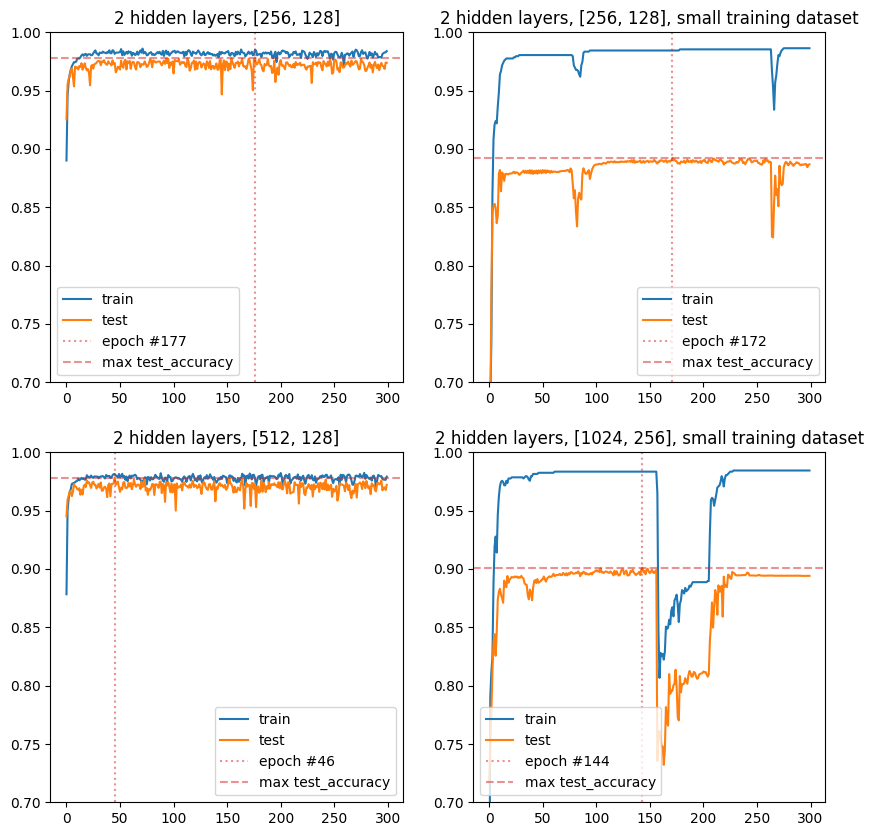

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sets = [set1, set2, set3, set4]
for s, ax in zip(sets, axes.flatten()):
    plot_accuracy(s, ax)
    ax.set_ylim(0.7, 1)
plt.show()

При достаточно большом количестве эпох начинает быть заметен эффект переобучения.